In [37]:
#!pip install missingpy

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from collections import defaultdict

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.dummy import *

# 1.3 Regressors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.dummy import DummyRegressor
import seaborn as sns
import pickle
from scipy.stats import spearmanr
from sklearn.inspection import permutation_importance
import time
from sklearn.impute import SimpleImputer, KNNImputer

In [2]:
df1 = pd.read_csv('ferm.csv', index_col=0, low_memory=False)
df2 = pd.read_csv('multiome_all.csv', index_col=0, low_memory=False)

In [3]:
df = df1.join(df2, lsuffix='_ferm', rsuffix='_resp')

In [4]:
df.shape

(4017, 350)

In [5]:
df.head()

,Molecule Type_ferm,∆ACO1_ferm,∆ACO2_ferm,∆AFG1_ferm,∆AFG3_ferm,∆AIM1_ferm,∆AIM25_ferm,∆AIM45_ferm,∆ARG5_ferm,∆ARO10_ferm,...,∆YLR253W_resp,∆YMC1_resp,∆YME1_resp,∆YME2_resp,∆YNK1_resp,∆YNL200C_resp,∆YPL109C_resp,∆YPR011C_resp,∆YPR098C_resp,∆YTA12_resp
Molecule Name,,,,,,,,,,,,,,,,,,,,,
2-Aminoadipic acid,Metabolite,0.105813,0.186528,0.021155,0.134079,0.023830,0.137408,-0.005947,-0.002167,-0.043112,...,0.062464,-0.240415,-0.288336,0.015382,-0.065253,-0.121216,0.017408,-0.135486,0.007603,-0.423365
2-Aminoheptanedioic acid,Metabolite,-0.046922,0.017442,NaN,0.019444,NaN,0.061292,NaN,0.006853,0.003939,...,-0.076417,0.054342,-0.075533,0.057787,-0.026580,-0.018729,-0.028484,0.017344,-0.023998,0.139293
2-Hydroxyglutaric acid,Metabolite,-0.160386,0.001247,NaN,0.023202,NaN,0.047440,NaN,0.040146,0.079808,...,-0.104570,0.123308,0.010166,0.105853,0.036476,0.015559,0.094804,0.021705,-0.026146,1.304837
2-Ketoglutaric acid,Metabolite,-3.100705,0.175777,-0.301172,-1.184277,-0.044801,0.602980,0.035784,0.076023,0.499469,...,NaN,-0.056086,-0.225929,0.110593,0.099505,0.144014,-0.240659,-0.026319,-0.761797,-3.262015
2-methylglyceric acid,Metabolite,0.152809,-0.005389,NaN,0.065120,NaN,-0.010126,NaN,0.023869,-0.078461,...,-0.112124,0.076747,-0.025162,0.160659,0.026205,0.061952,0.011081,0.048210,0.127693,0.153886


In [6]:
cln = df.dropna()
cln.shape

(937, 350)

In [7]:
cln.iloc[:,1]

Molecule Name
AAP1 (YHR047c)    0.751019
ABF1 (YKL112W)    0.028802
ABF2 (YMR072w)   -0.350154
ACC1 (YNR016c)   -0.028257
ACO1 (YLR304c)   -6.671317
                    ...   
ZPR1 (YGR211w)    0.097760
ZRC1 (YMR243c)   -0.108935
ZTA1 (YBR046c)    0.413226
ZUO1 (YGR285c)   -0.190598
ZWF1 (YNL241C)   -0.092726
Name: ∆ACO1_ferm, Length: 937, dtype: float64

In [8]:
cln.iloc[1,:]

Molecule Type_ferm     Protein
∆ACO1_ferm            0.028802
∆ACO2_ferm            0.063491
∆AFG1_ferm            0.160664
∆AFG3_ferm            0.092154
                        ...   
∆YNL200C_resp        -0.067838
∆YPL109C_resp        -0.035062
∆YPR011C_resp         0.123657
∆YPR098C_resp        -0.022935
∆YTA12_resp           0.211829
Name: ABF1 (YKL112W), Length: 350, dtype: object

In [9]:
cln.iloc[:,1].hist()

<AxesSubplot:>

In [10]:
cln

,Molecule Type_ferm,∆ACO1_ferm,∆ACO2_ferm,∆AFG1_ferm,∆AFG3_ferm,∆AIM1_ferm,∆AIM25_ferm,∆AIM45_ferm,∆ARG5_ferm,∆ARO10_ferm,...,∆YLR253W_resp,∆YMC1_resp,∆YME1_resp,∆YME2_resp,∆YNK1_resp,∆YNL200C_resp,∆YPL109C_resp,∆YPR011C_resp,∆YPR098C_resp,∆YTA12_resp
Molecule Name,,,,,,,,,,,,,,,,,,,,,
AAP1 (YHR047c),Protein,0.751019,-0.016861,0.256383,0.213589,0.085396,0.071200,0.159166,-0.074533,-0.076910,...,0.104360,-0.145274,-0.018050,0.016820,-0.224921,0.043637,0.128156,0.004671,0.047887,0.447347
ABF1 (YKL112W),Protein,0.028802,0.063491,0.160664,0.092154,-0.016851,0.083002,-0.046234,-0.009823,0.103872,...,0.019639,0.182225,0.096255,0.164159,-0.014874,-0.067838,-0.035062,0.123657,-0.022935,0.211829
ABF2 (YMR072w),Protein,-0.350154,-0.072165,0.044126,-0.339290,0.079841,0.102839,-0.037274,-0.019201,0.081535,...,-0.033673,0.087844,0.006192,0.053041,-0.226512,-0.194525,-0.020600,0.103124,0.167302,-0.715571
ACC1 (YNR016c),Protein,-0.028257,-0.078073,0.028136,0.034625,0.098908,0.002011,-0.042940,0.151140,-0.002208,...,0.298097,0.223406,0.514546,-0.120046,0.017379,-0.146952,0.388154,0.358105,-0.288019,-0.419743
ACO1 (YLR304c),Protein,-6.671317,0.089245,0.122311,1.535070,-0.061093,0.216090,0.234654,-0.015596,0.090036,...,-0.063711,-0.347006,-0.340689,-0.076134,-0.101655,0.123218,-0.303637,-0.026917,-0.041934,-1.067059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZPR1 (YGR211w),Protein,0.097760,0.107521,-0.188865,-0.544851,-0.063031,-0.026361,0.023289,-0.101657,-0.021450,...,0.112129,0.010742,0.022656,0.023003,-0.002474,-0.052660,0.080301,-0.064275,0.020902,0.063735
ZRC1 (YMR243c),Protein,-0.108935,0.096859,0.353060,-0.230110,-0.268208,0.024785,-0.124756,0.360410,0.162655,...,-0.353746,-0.051600,-0.226267,0.062708,0.017760,0.117796,0.073009,0.135610,0.098139,0.268805
ZTA1 (YBR046c),Protein,0.413226,0.042446,0.161205,1.481629,0.098579,0.096035,0.106340,-0.224691,-0.259273,...,0.172521,-0.158325,-0.133670,-0.029616,0.115582,-0.116475,0.198472,0.000348,0.172457,-0.544553


In [11]:
protein = cln.loc[cln['Molecule Type_ferm'].isin(['Protein'])]
protein = protein.drop(columns=['Molecule Type_ferm', 'Molecule Type_resp'])
protein.shape

(873, 348)

In [12]:
lipid = cln.loc[cln['Molecule Type_ferm'].isin(['Lipid'])]
lipid = lipid.drop(columns=['Molecule Type_ferm', 'Molecule Type_resp'])
lipid.shape

(50, 348)

In [13]:
met = cln.loc[cln['Molecule Type_ferm'].isin(['Metabolite'])]
met = met.drop(columns=['Molecule Type_ferm', 'Molecule Type_resp'])
met.shape

(14, 348)

In [14]:
df.head()

,Molecule Type_ferm,∆ACO1_ferm,∆ACO2_ferm,∆AFG1_ferm,∆AFG3_ferm,∆AIM1_ferm,∆AIM25_ferm,∆AIM45_ferm,∆ARG5_ferm,∆ARO10_ferm,...,∆YLR253W_resp,∆YMC1_resp,∆YME1_resp,∆YME2_resp,∆YNK1_resp,∆YNL200C_resp,∆YPL109C_resp,∆YPR011C_resp,∆YPR098C_resp,∆YTA12_resp
Molecule Name,,,,,,,,,,,,,,,,,,,,,
2-Aminoadipic acid,Metabolite,0.105813,0.186528,0.021155,0.134079,0.023830,0.137408,-0.005947,-0.002167,-0.043112,...,0.062464,-0.240415,-0.288336,0.015382,-0.065253,-0.121216,0.017408,-0.135486,0.007603,-0.423365
2-Aminoheptanedioic acid,Metabolite,-0.046922,0.017442,NaN,0.019444,NaN,0.061292,NaN,0.006853,0.003939,...,-0.076417,0.054342,-0.075533,0.057787,-0.026580,-0.018729,-0.028484,0.017344,-0.023998,0.139293
2-Hydroxyglutaric acid,Metabolite,-0.160386,0.001247,NaN,0.023202,NaN,0.047440,NaN,0.040146,0.079808,...,-0.104570,0.123308,0.010166,0.105853,0.036476,0.015559,0.094804,0.021705,-0.026146,1.304837
2-Ketoglutaric acid,Metabolite,-3.100705,0.175777,-0.301172,-1.184277,-0.044801,0.602980,0.035784,0.076023,0.499469,...,NaN,-0.056086,-0.225929,0.110593,0.099505,0.144014,-0.240659,-0.026319,-0.761797,-3.262015
2-methylglyceric acid,Metabolite,0.152809,-0.005389,NaN,0.065120,NaN,-0.010126,NaN,0.023869,-0.078461,...,-0.112124,0.076747,-0.025162,0.160659,0.026205,0.061952,0.011081,0.048210,0.127693,0.153886


# make full X data (proteins with KNN imputation)

In [15]:

pf = df.loc[df['Molecule Type_ferm'].isin(['Protein'])]
pf = pf.drop(columns = ['Molecule Type_ferm', 'Molecule Type_resp'])
kimpp = KNNImputer(n_neighbors=2)
pfi = kimpp.fit_transform(pf)
X_data = np.asarray(pfi.T)
X_df = pd.DataFrame(data = pfi.T, index = pf.T.index, columns = pf.T.columns)

In [16]:
print(pf.shape)

(3690, 348)


In [17]:
pf.T.head()


Molecule Name,AAC1 (YMR056c),AAC3 (YBR085w),AAH1 (YNL141w),AAP1 (YHR047c),AAR2 (YBL074c),AAT1 (YKL106w),AAT2 (YLR027C),ABD1 (YBR236c),ABF1 (YKL112W),ABF2 (YMR072w),...,ZIM17 (YNL310C),ZPR1 (YGR211w),ZRC1 (YMR243c),ZRG17 (YNR039c),ZRT1 (YGL255w),ZRT3 (YKL175w),ZTA1 (YBR046c),ZUO1 (YGR285c),ZWF1 (YNL241C),coa6 (YMR244c-a)
∆ACO1_ferm,1.027358,-0.931070,-0.075490,0.751019,NaN,-0.216840,0.456241,0.025649,0.028802,-0.350154,...,0.145498,0.097760,-0.108935,-1.735153,-2.090227,0.718975,0.413226,-0.190598,-0.092726,NaN
∆ACO2_ferm,0.913050,-0.700856,-0.189610,-0.016861,NaN,-0.250856,0.037289,-0.008014,0.063491,-0.072165,...,0.105484,0.107521,0.096859,0.075786,-1.312650,0.480919,0.042446,-0.101847,0.015870,NaN
∆AFG1_ferm,0.478310,NaN,0.017919,0.256383,NaN,0.198294,0.005559,-0.005964,0.160664,0.044126,...,-0.191008,-0.188865,0.353060,NaN,NaN,0.080397,0.161205,-0.144780,-0.060676,NaN
∆AFG3_ferm,1.020635,-0.604662,-1.075854,0.213589,1.114418,-0.539066,0.653836,0.874242,0.092154,-0.339290,...,-0.083140,-0.544851,-0.230110,-0.404250,NaN,0.292918,1.481629,-0.119340,0.358215,0.083984
∆AIM1_ferm,0.944649,NaN,-0.012883,0.085396,NaN,0.333719,0.040886,0.082914,-0.016851,0.079841,...,0.900733,-0.063031,-0.268208,NaN,NaN,0.478339,0.098579,-0.177158,-0.080162,NaN


In [18]:
X_df.head()

Molecule Name,AAC1 (YMR056c),AAC3 (YBR085w),AAH1 (YNL141w),AAP1 (YHR047c),AAR2 (YBL074c),AAT1 (YKL106w),AAT2 (YLR027C),ABD1 (YBR236c),ABF1 (YKL112W),ABF2 (YMR072w),...,ZIM17 (YNL310C),ZPR1 (YGR211w),ZRC1 (YMR243c),ZRG17 (YNR039c),ZRT1 (YGL255w),ZRT3 (YKL175w),ZTA1 (YBR046c),ZUO1 (YGR285c),ZWF1 (YNL241C),coa6 (YMR244c-a)
∆ACO1_ferm,1.027358,-0.931070,-0.075490,0.751019,0.081753,-0.216840,0.456241,0.025649,0.028802,-0.350154,...,0.145498,0.097760,-0.108935,-1.735153,-2.090227,0.718975,0.413226,-0.190598,-0.092726,-0.206861
∆ACO2_ferm,0.913050,-0.700856,-0.189610,-0.016861,-0.047547,-0.250856,0.037289,-0.008014,0.063491,-0.072165,...,0.105484,0.107521,0.096859,0.075786,-1.312650,0.480919,0.042446,-0.101847,0.015870,-0.148295
∆AFG1_ferm,0.478310,0.309610,0.017919,0.256383,-0.067798,0.198294,0.005559,-0.005964,0.160664,0.044126,...,-0.191008,-0.188865,0.353060,0.055466,-0.036283,0.080397,0.161205,-0.144780,-0.060676,0.049095
∆AFG3_ferm,1.020635,-0.604662,-1.075854,0.213589,1.114418,-0.539066,0.653836,0.874242,0.092154,-0.339290,...,-0.083140,-0.544851,-0.230110,-0.404250,0.415888,0.292918,1.481629,-0.119340,0.358215,0.083984
∆AIM1_ferm,0.944649,0.210585,-0.012883,0.085396,0.014639,0.333719,0.040886,0.082914,-0.016851,0.079841,...,0.900733,-0.063031,-0.268208,-0.048723,0.141479,0.478339,0.098579,-0.177158,-0.080162,0.034016


# Make lipid data

In [19]:
lf = df.loc[df['Molecule Type_ferm'].isin(['Lipid'])]
lf = lf.drop(columns = ['Molecule Type_ferm', 'Molecule Type_resp'])
kimpl = KNNImputer(n_neighbors=2)
lfi = kimpl.fit_transform(lf)
l_data = np.asarray(lfi.T)
l_df = pd.DataFrame(data = lfi.T, index = lf.T.index, columns = lf.T.columns)

In [20]:
l_df.shape

(348, 54)

In [21]:
lf.T.head()

Molecule Name,CDP-DAG(16:0/16:1),CDP-DAG(16:1/16:1),CDP-DAG(18:1/16:0),CDP-DAG(18:1/16:1),CL(64:2),CL(64:3),CL(64:4),CL(66:2),CL(66:3),CL(66:4),...,PI(18:1/16:0),PI(18:1/16:1),PPAB6,PPHB6 (HHB),PS(16:0/16:1),PS(16:1/16:1),PS(18:1/16:0),PS(18:1/16:1),Palmitic acid (FA(16:0)),Palmitoleic acid (FA(16:1))
∆ACO1_ferm,3.419699,0.664730,0.688347,1.194858,-0.823529,-1.480092,-0.893767,-0.274078,-1.039278,-0.805031,...,0.797332,-0.112199,-4.480477,-1.548124,0.366530,0.052777,0.331649,-0.150699,0.930794,0.697442
∆ACO2_ferm,3.120459,0.065464,0.415703,0.681273,0.033764,-1.245535,-1.895153,0.514908,-0.615560,-1.616264,...,1.363328,0.480442,-0.603568,-0.128207,0.231811,-0.105454,0.476260,0.035573,0.006724,-0.052428
∆AFG1_ferm,1.267527,0.799436,0.751114,1.147861,-0.226793,-0.692840,-1.001758,0.098246,-0.420465,-0.757422,...,0.528387,0.023587,-0.030731,-0.089474,0.073845,-0.176457,0.403979,-0.013077,-0.452081,-0.741690
∆AFG3_ferm,0.711636,0.285306,1.264703,1.366707,-1.812706,-2.346136,-2.198923,-0.564247,-1.529007,-1.500905,...,1.175134,0.237374,-3.417358,-2.371940,-0.277401,-0.552769,0.440838,0.134105,0.461733,0.037159
∆AIM1_ferm,0.087026,0.075632,-0.862404,-0.591217,-0.014789,-0.089456,-0.006095,-0.011877,0.041125,0.053315,...,0.395115,0.062497,-0.464329,-0.010581,0.070627,0.001911,0.308816,0.104037,-0.436414,-0.985671


In [22]:

l_df.head()

Molecule Name,CDP-DAG(16:0/16:1),CDP-DAG(16:1/16:1),CDP-DAG(18:1/16:0),CDP-DAG(18:1/16:1),CL(64:2),CL(64:3),CL(64:4),CL(66:2),CL(66:3),CL(66:4),...,PI(18:1/16:0),PI(18:1/16:1),PPAB6,PPHB6 (HHB),PS(16:0/16:1),PS(16:1/16:1),PS(18:1/16:0),PS(18:1/16:1),Palmitic acid (FA(16:0)),Palmitoleic acid (FA(16:1))
∆ACO1_ferm,3.419699,0.664730,0.688347,1.194858,-0.823529,-1.480092,-0.893767,-0.274078,-1.039278,-0.805031,...,0.797332,-0.112199,-4.480477,-1.548124,0.366530,0.052777,0.331649,-0.150699,0.930794,0.697442
∆ACO2_ferm,3.120459,0.065464,0.415703,0.681273,0.033764,-1.245535,-1.895153,0.514908,-0.615560,-1.616264,...,1.363328,0.480442,-0.603568,-0.128207,0.231811,-0.105454,0.476260,0.035573,0.006724,-0.052428
∆AFG1_ferm,1.267527,0.799436,0.751114,1.147861,-0.226793,-0.692840,-1.001758,0.098246,-0.420465,-0.757422,...,0.528387,0.023587,-0.030731,-0.089474,0.073845,-0.176457,0.403979,-0.013077,-0.452081,-0.741690
∆AFG3_ferm,0.711636,0.285306,1.264703,1.366707,-1.812706,-2.346136,-2.198923,-0.564247,-1.529007,-1.500905,...,1.175134,0.237374,-3.417358,-2.371940,-0.277401,-0.552769,0.440838,0.134105,0.461733,0.037159
∆AIM1_ferm,0.087026,0.075632,-0.862404,-0.591217,-0.014789,-0.089456,-0.006095,-0.011877,0.041125,0.053315,...,0.395115,0.062497,-0.464329,-0.010581,0.070627,0.001911,0.308816,0.104037,-0.436414,-0.985671


In [23]:
lipid.T.head()

Molecule Name,CDP-DAG(16:1/16:1),CDP-DAG(18:1/16:0),CDP-DAG(18:1/16:1),CL(64:2),CL(64:3),CL(64:4),CL(66:2),CL(66:3),CL(66:4),CL(68:3),...,PI(16:1/16:1),PI(18:1/16:0),PI(18:1/16:1),PPHB6 (HHB),PS(16:0/16:1),PS(16:1/16:1),PS(18:1/16:0),PS(18:1/16:1),Palmitic acid (FA(16:0)),Palmitoleic acid (FA(16:1))
∆ACO1_ferm,0.664730,0.688347,1.194858,-0.823529,-1.480092,-0.893767,-0.274078,-1.039278,-0.805031,-0.567570,...,-0.125709,0.797332,-0.112199,-1.548124,0.366530,0.052777,0.331649,-0.150699,0.930794,0.697442
∆ACO2_ferm,0.065464,0.415703,0.681273,0.033764,-1.245535,-1.895153,0.514908,-0.615560,-1.616264,0.025955,...,0.155765,1.363328,0.480442,-0.128207,0.231811,-0.105454,0.476260,0.035573,0.006724,-0.052428
∆AFG1_ferm,0.799436,0.751114,1.147861,-0.226793,-0.692840,-1.001758,0.098246,-0.420465,-0.757422,-0.059692,...,-0.189165,0.528387,0.023587,-0.089474,0.073845,-0.176457,0.403979,-0.013077,-0.452081,-0.741690
∆AFG3_ferm,0.285306,1.264703,1.366707,-1.812706,-2.346136,-2.198923,-0.564247,-1.529007,-1.500905,-0.073286,...,-0.635331,1.175134,0.237374,-2.371940,-0.277401,-0.552769,0.440838,0.134105,0.461733,0.037159
∆AIM1_ferm,0.075632,-0.862404,-0.591217,-0.014789,-0.089456,-0.006095,-0.011877,0.041125,0.053315,0.139582,...,-0.065955,0.395115,0.062497,-0.010581,0.070627,0.001911,0.308816,0.104037,-0.436414,-0.985671


# Make metabolite data

In [24]:
mf = df.loc[df['Molecule Type_ferm'].isin(['Metabolite'])]
mf = mf.drop(columns = ['Molecule Type_ferm', 'Molecule Type_resp'])
kimpm = KNNImputer(n_neighbors=2)
mfi = kimpm.fit_transform(mf)
m_data = np.asarray(mfi.T)
m_df = pd.DataFrame(data = mfi.T, index = mf.T.index, columns = mf.T.columns)

In [25]:
m_df.head()

Molecule Name,2-Aminoadipic acid,2-Aminoheptanedioic acid,2-Hydroxyglutaric acid,2-Ketoglutaric acid,2-methylglyceric acid,2-phosphoplgyceric acid,3-deoxytetronic acid,4-aminobutanoic acid,4-hydroxybenzaldehyde (4-HBZ),4-hydroxybenzoic acid,...,"Unidentified metabolite, RT 8.3297 (F)","Unidentified metabolite, RT 9.359 (F)","Unidentified metabolite, RT 9.4329 (F)",Uracil,Urea,Uridine,Valine,Xanthine,d-Aminolevulinic acid,p-aminobenzoic acid (paba)
∆ACO1_ferm,0.105813,-0.046922,-0.160386,-3.100705,0.152809,-0.068557,0.097576,0.092380,0.111254,0.039976,...,0.247575,0.757754,-0.850374,0.151996,0.051869,0.526726,0.170861,0.096989,0.212538,0.029519
∆ACO2_ferm,0.186528,0.017442,0.001247,0.175777,-0.005389,0.011207,-0.020897,-0.045765,-0.055550,0.018527,...,0.017319,0.345852,-1.143264,-0.147294,-0.037701,-0.061551,-0.011697,0.045880,-0.062647,0.016182
∆AFG1_ferm,0.021155,-0.090160,0.005798,-0.301172,-0.090160,-0.415929,-0.149219,0.126804,0.106055,0.005798,...,-0.073572,0.273151,-0.955179,-0.090841,-0.102052,0.385031,0.034921,-0.139681,-0.081586,-0.089379
∆AFG3_ferm,0.134079,0.019444,0.023202,-1.184277,0.065120,-0.514369,0.049403,-0.097135,-0.058410,-0.131066,...,-0.191740,-0.144094,-0.104224,-0.075256,0.006250,-0.172135,-0.006362,0.044979,-0.240934,-0.103350
∆AIM1_ferm,0.023830,-0.081785,-0.005057,-0.044801,-0.081785,-0.411698,-0.098746,0.084657,0.046107,-0.005057,...,-0.027018,0.299259,-0.707151,-0.156239,0.056154,0.154470,0.054428,-0.126495,-0.338774,-0.017760


In [26]:
met.T.head()

Molecule Name,Aspartic Acid,Biotin,Citric acid,Fumaric acid,Malic acid,Orotic Acid,"Unidentified metabolite, RT 13.4093","Unidentified metabolite, RT 13.7754","Unidentified metabolite, RT 15.2271","Unidentified metabolite, RT 15.6883","Unidentified metabolite, RT 18.1647","Unidentified metabolite, RT 19.3586","Unidentified metabolite, RT 20.8307","Unidentified metabolite, RT 24.0266"
∆ACO1_ferm,0.235656,-0.430319,0.674584,-0.078033,-0.208331,-1.404887,0.012682,0.032268,0.078658,0.377962,-0.447998,-0.052325,0.021573,0.086789
∆ACO2_ferm,-0.069608,-0.071711,0.064713,-0.014937,0.007807,-0.013839,0.015107,-0.010092,0.054792,0.144064,-0.613015,-0.101174,-0.150682,0.075861
∆AFG1_ferm,0.266743,0.133348,-0.058175,0.041785,0.067030,0.330998,-0.093141,-0.070497,-0.107470,-0.071857,-0.071746,-0.235871,-0.081330,-0.072293
∆AFG3_ferm,0.196812,-1.745697,1.295234,-0.098605,-0.140285,-2.232179,0.058073,0.068515,0.045176,0.035042,0.124789,-0.060684,0.034559,-0.171150
∆AIM1_ferm,0.360779,0.180801,-0.022616,0.091055,0.176234,0.482570,0.027450,-0.007479,-0.071483,0.050435,-0.149174,-0.212003,-0.179751,-0.043942


In [27]:
m_df.shape

(348, 273)

# Make X_data and y_data from the matrix

In [28]:
pf.T.index

Index(['∆ACO1_ferm', '∆ACO2_ferm', '∆AFG1_ferm', '∆AFG3_ferm', '∆AIM1_ferm',
       '∆AIM25_ferm', '∆AIM45_ferm', '∆ARG5_ferm', '∆ARO10_ferm', '∆ATG1_ferm',
       ...
       '∆YLR253W_resp', '∆YMC1_resp', '∆YME1_resp', '∆YME2_resp', '∆YNK1_resp',
       '∆YNL200C_resp', '∆YPL109C_resp', '∆YPR011C_resp', '∆YPR098C_resp',
       '∆YTA12_resp'],
      dtype='object', length=348)

In [29]:
ml_df = l_df.join(m_df)
ml_data = np.asarray(ml_df)

# Split train/test

In [30]:
train_index, test_index= train_test_split(range(len(X_data)),
                                                              test_size = 0.10, 
                                                              random_state = 42)
print(len(train_index))
print(len(test_index))

313
35


In [31]:
## replace this with the using indexes
pro_train_all, pro_test, met_train_all, met_test = train_test_split(X_df, 
                                                              m_df, 
                                                              test_size = 0.10, 
                                                              random_state = 42)

pro_train_all, pro_test, lip_train_all, lip_test = train_test_split(X_df,
                                                                      l_df,
                                                                      test_size = 0.10,
                                                                      random_state = 42)

pro_train_all, pro_test, ml_train_all, ml_test = train_test_split(X_df,
                                                                      ml_df,
                                                                      test_size = 0.10,
                                                                      random_state = 42)

pro_train, pro_val, met_train, met_val = train_test_split(pro_train_all, met_train_all, 
                                                          test_size = 0.11, random_state = 42)

pro_train, pro_val, lip_train, lip_val = train_test_split(pro_train_all, lip_train_all,
                                                          test_size = 0.11, random_state = 42)


print('Training Prot Shape:', pro_train.shape)
print('Training met Shape:', met_train.shape)
print('Training lip Shape:', lip_train.shape)

print('Training lip Shape:', ml_train_all.shape)

print('Validation Prot Shape:', pro_val.shape)
print('Validation met Shape:', met_val.shape)
print('Validation met Shape:', lip_val.shape)

print('Testing Prot Shape:', pro_test.shape)
print('Testing met Shape:', met_test.shape)
print('Testing lip Shape:', lip_test.shape)

Training Prot Shape: (278, 3690)
Training met Shape: (278, 273)
Training lip Shape: (278, 54)
Training lip Shape: (313, 327)
Validation Prot Shape: (35, 3690)
Validation met Shape: (35, 273)
Validation met Shape: (35, 54)
Testing Prot Shape: (35, 3690)
Testing met Shape: (35, 273)
Testing lip Shape: (35, 54)


In [32]:
X_df

Molecule Name,AAC1 (YMR056c),AAC3 (YBR085w),AAH1 (YNL141w),AAP1 (YHR047c),AAR2 (YBL074c),AAT1 (YKL106w),AAT2 (YLR027C),ABD1 (YBR236c),ABF1 (YKL112W),ABF2 (YMR072w),...,ZIM17 (YNL310C),ZPR1 (YGR211w),ZRC1 (YMR243c),ZRG17 (YNR039c),ZRT1 (YGL255w),ZRT3 (YKL175w),ZTA1 (YBR046c),ZUO1 (YGR285c),ZWF1 (YNL241C),coa6 (YMR244c-a)
∆ACO1_ferm,1.027358,-0.931070,-0.075490,0.751019,0.081753,-0.216840,0.456241,0.025649,0.028802,-0.350154,...,0.145498,0.097760,-0.108935,-1.735153,-2.090227,0.718975,0.413226,-0.190598,-0.092726,-0.206861
∆ACO2_ferm,0.913050,-0.700856,-0.189610,-0.016861,-0.047547,-0.250856,0.037289,-0.008014,0.063491,-0.072165,...,0.105484,0.107521,0.096859,0.075786,-1.312650,0.480919,0.042446,-0.101847,0.015870,-0.148295
∆AFG1_ferm,0.478310,0.309610,0.017919,0.256383,-0.067798,0.198294,0.005559,-0.005964,0.160664,0.044126,...,-0.191008,-0.188865,0.353060,0.055466,-0.036283,0.080397,0.161205,-0.144780,-0.060676,0.049095
∆AFG3_ferm,1.020635,-0.604662,-1.075854,0.213589,1.114418,-0.539066,0.653836,0.874242,0.092154,-0.339290,...,-0.083140,-0.544851,-0.230110,-0.404250,0.415888,0.292918,1.481629,-0.119340,0.358215,0.083984
∆AIM1_ferm,0.944649,0.210585,-0.012883,0.085396,0.014639,0.333719,0.040886,0.082914,-0.016851,0.079841,...,0.900733,-0.063031,-0.268208,-0.048723,0.141479,0.478339,0.098579,-0.177158,-0.080162,0.034016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
∆YNL200C_resp,0.188296,-0.055459,0.138652,0.043637,0.017940,-0.119204,-0.046859,-0.026581,-0.067838,-0.194525,...,0.144710,-0.052660,0.117796,0.093874,0.194442,0.265456,-0.116475,-0.013342,-0.050496,0.182534
∆YPL109C_resp,0.023281,-1.034971,-0.138375,0.128156,0.052813,0.338972,-0.001309,0.042418,-0.035062,-0.020600,...,-0.262800,0.080301,0.073009,0.071992,0.021973,-0.093578,0.198472,0.041066,0.089830,-0.385306
∆YPR011C_resp,0.172790,-0.046781,0.533878,0.004671,0.028777,0.000889,0.039297,-0.005885,0.123657,0.103124,...,-0.035129,-0.064275,0.135610,0.005366,-0.310254,-0.030361,0.000348,0.060036,0.006338,0.010960
∆YPR098C_resp,0.275941,0.095745,-0.211223,0.047887,0.100656,0.059019,0.050524,0.168455,-0.022935,0.167302,...,-0.190294,0.020902,0.098139,-0.067426,-0.210995,0.336545,0.172457,-0.054758,0.015196,0.112605


In [33]:
l_df

Molecule Name,CDP-DAG(16:0/16:1),CDP-DAG(16:1/16:1),CDP-DAG(18:1/16:0),CDP-DAG(18:1/16:1),CL(64:2),CL(64:3),CL(64:4),CL(66:2),CL(66:3),CL(66:4),...,PI(18:1/16:0),PI(18:1/16:1),PPAB6,PPHB6 (HHB),PS(16:0/16:1),PS(16:1/16:1),PS(18:1/16:0),PS(18:1/16:1),Palmitic acid (FA(16:0)),Palmitoleic acid (FA(16:1))
∆ACO1_ferm,3.419699,0.664730,0.688347,1.194858,-0.823529,-1.480092,-0.893767,-0.274078,-1.039278,-0.805031,...,0.797332,-0.112199,-4.480477,-1.548124,0.366530,0.052777,0.331649,-0.150699,0.930794,0.697442
∆ACO2_ferm,3.120459,0.065464,0.415703,0.681273,0.033764,-1.245535,-1.895153,0.514908,-0.615560,-1.616264,...,1.363328,0.480442,-0.603568,-0.128207,0.231811,-0.105454,0.476260,0.035573,0.006724,-0.052428
∆AFG1_ferm,1.267527,0.799436,0.751114,1.147861,-0.226793,-0.692840,-1.001758,0.098246,-0.420465,-0.757422,...,0.528387,0.023587,-0.030731,-0.089474,0.073845,-0.176457,0.403979,-0.013077,-0.452081,-0.741690
∆AFG3_ferm,0.711636,0.285306,1.264703,1.366707,-1.812706,-2.346136,-2.198923,-0.564247,-1.529007,-1.500905,...,1.175134,0.237374,-3.417358,-2.371940,-0.277401,-0.552769,0.440838,0.134105,0.461733,0.037159
∆AIM1_ferm,0.087026,0.075632,-0.862404,-0.591217,-0.014789,-0.089456,-0.006095,-0.011877,0.041125,0.053315,...,0.395115,0.062497,-0.464329,-0.010581,0.070627,0.001911,0.308816,0.104037,-0.436414,-0.985671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
∆YNL200C_resp,-0.227797,-1.247932,1.385713,-0.304165,0.240231,-0.476027,-1.421958,0.648930,0.148955,-0.777583,...,1.557867,0.419967,-0.464388,-0.152139,0.163613,-0.220417,0.521513,-0.088359,-0.215041,1.440980
∆YPL109C_resp,1.812912,-0.938787,1.710798,2.039189,0.052106,-0.836089,-1.456750,0.501030,-0.252559,-1.152242,...,1.191045,0.482715,-1.965038,0.029609,0.347207,0.039420,0.599249,0.060356,0.763704,1.026830
∆YPR011C_resp,-1.773808,0.745395,0.141553,-0.063925,0.227825,0.015698,-0.073966,0.413895,0.177092,-0.062052,...,0.075071,0.002546,0.029960,0.192871,0.041967,0.099905,0.017259,-0.093225,-0.583945,-0.195057
∆YPR098C_resp,-0.326343,-0.174227,-2.947637,1.419726,0.163195,0.205509,0.208416,0.242219,0.181501,0.226343,...,-0.238261,-0.251148,-1.996608,-1.214817,-0.403929,-0.175952,-0.357542,-0.204038,-0.816653,-0.589205


In [34]:
lfi.T

array([[ 3.4196985 ,  0.66473015,  0.68834736, ..., -0.15069877,
         0.93079354,  0.69744248],
       [ 3.12045895,  0.06546373,  0.41570306, ...,  0.03557332,
         0.00672417, -0.05242827],
       [ 1.26752698,  0.79943626,  0.75111432, ..., -0.01307737,
        -0.45208069, -0.74169044],
       ...,
       [-1.77380755,  0.74539477,  0.14155264, ..., -0.09322479,
        -0.58394504, -0.19505702],
       [-0.32634336, -0.17422652, -2.94763717, ..., -0.2040381 ,
        -0.81665254, -0.58920531],
       [-0.52402579,  3.17078884,  2.39174275, ...,  0.32605987,
         0.26973396, -0.4118651 ]])

In [35]:
pro_train_all

Molecule Name,AAC1 (YMR056c),AAC3 (YBR085w),AAH1 (YNL141w),AAP1 (YHR047c),AAR2 (YBL074c),AAT1 (YKL106w),AAT2 (YLR027C),ABD1 (YBR236c),ABF1 (YKL112W),ABF2 (YMR072w),...,ZIM17 (YNL310C),ZPR1 (YGR211w),ZRC1 (YMR243c),ZRG17 (YNR039c),ZRT1 (YGL255w),ZRT3 (YKL175w),ZTA1 (YBR046c),ZUO1 (YGR285c),ZWF1 (YNL241C),coa6 (YMR244c-a)
∆FMP40_ferm,0.047637,-0.006668,-0.172729,-0.011075,0.290285,-0.066712,0.042154,0.023856,0.135258,0.135579,...,0.183586,-0.039591,-0.117804,-0.084507,-0.772256,-0.225941,0.126064,-0.012601,0.050113,0.600410
∆EMC6_ferm,-0.046869,0.039059,-0.088535,0.120546,-0.019901,0.108467,-0.101967,0.052949,0.021170,0.032160,...,-0.171035,0.114423,-0.053724,-0.013561,-0.323682,-0.037947,-0.236446,-0.005708,0.041526,-0.031103
∆COQ8_ferm,-0.011721,-0.283675,-0.200855,0.209266,-0.067393,-0.288907,0.279415,-0.007340,0.014956,-0.042974,...,-0.257338,0.045997,-0.385247,-0.395868,-1.460453,0.154610,0.421243,-0.108719,0.251254,-0.143656
∆FMP42_resp,0.181011,0.146656,-0.103947,-0.029151,0.004236,-0.105065,-0.018644,0.163136,-0.010272,0.075577,...,-0.210970,-0.027879,-0.037602,-0.189607,0.049878,0.242443,0.174137,-0.064560,-0.028791,0.019368
∆YLF2_resp,0.227460,0.031518,-0.270960,0.150171,0.032194,-0.063489,0.153989,0.246880,-0.077488,0.140831,...,-0.302885,-0.055382,0.040534,-0.129919,-0.380733,0.234171,0.392139,-0.113624,-0.162459,0.191849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
∆ATP3_resp,-1.418110,-1.330481,-1.015563,0.030038,0.204659,-0.880269,0.255783,0.139988,-0.071601,-0.582019,...,0.420295,-0.185492,0.078780,-0.841088,-0.820626,0.200105,0.189781,0.249733,0.199851,0.057678
∆IMO32_ferm,0.523483,-0.531251,0.012648,0.163501,0.038070,0.063174,0.049177,-0.170229,0.030461,0.089844,...,0.892281,0.010846,0.149227,0.103919,-0.053129,0.180309,0.229916,0.073197,0.014968,0.041787
∆MRX3_ferm,0.193206,0.068300,-0.084356,0.018731,-0.065048,0.003252,-0.117245,-0.130762,0.067750,0.034800,...,-0.009235,0.074296,0.210259,-0.254139,-1.258307,0.139752,0.210254,-0.070239,0.149625,-0.095524
∆MMM1_resp,-2.253985,-2.217771,1.137577,0.507839,-0.074947,0.048444,-0.131776,0.253076,0.147415,-0.927764,...,-0.372965,-0.263928,-0.169370,-0.293220,-2.022716,-0.304220,-0.805099,0.000914,0.342809,-0.193544


In [36]:
pro_train_all

Molecule Name,AAC1 (YMR056c),AAC3 (YBR085w),AAH1 (YNL141w),AAP1 (YHR047c),AAR2 (YBL074c),AAT1 (YKL106w),AAT2 (YLR027C),ABD1 (YBR236c),ABF1 (YKL112W),ABF2 (YMR072w),...,ZIM17 (YNL310C),ZPR1 (YGR211w),ZRC1 (YMR243c),ZRG17 (YNR039c),ZRT1 (YGL255w),ZRT3 (YKL175w),ZTA1 (YBR046c),ZUO1 (YGR285c),ZWF1 (YNL241C),coa6 (YMR244c-a)
∆FMP40_ferm,0.047637,-0.006668,-0.172729,-0.011075,0.290285,-0.066712,0.042154,0.023856,0.135258,0.135579,...,0.183586,-0.039591,-0.117804,-0.084507,-0.772256,-0.225941,0.126064,-0.012601,0.050113,0.600410
∆EMC6_ferm,-0.046869,0.039059,-0.088535,0.120546,-0.019901,0.108467,-0.101967,0.052949,0.021170,0.032160,...,-0.171035,0.114423,-0.053724,-0.013561,-0.323682,-0.037947,-0.236446,-0.005708,0.041526,-0.031103
∆COQ8_ferm,-0.011721,-0.283675,-0.200855,0.209266,-0.067393,-0.288907,0.279415,-0.007340,0.014956,-0.042974,...,-0.257338,0.045997,-0.385247,-0.395868,-1.460453,0.154610,0.421243,-0.108719,0.251254,-0.143656
∆FMP42_resp,0.181011,0.146656,-0.103947,-0.029151,0.004236,-0.105065,-0.018644,0.163136,-0.010272,0.075577,...,-0.210970,-0.027879,-0.037602,-0.189607,0.049878,0.242443,0.174137,-0.064560,-0.028791,0.019368
∆YLF2_resp,0.227460,0.031518,-0.270960,0.150171,0.032194,-0.063489,0.153989,0.246880,-0.077488,0.140831,...,-0.302885,-0.055382,0.040534,-0.129919,-0.380733,0.234171,0.392139,-0.113624,-0.162459,0.191849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
∆ATP3_resp,-1.418110,-1.330481,-1.015563,0.030038,0.204659,-0.880269,0.255783,0.139988,-0.071601,-0.582019,...,0.420295,-0.185492,0.078780,-0.841088,-0.820626,0.200105,0.189781,0.249733,0.199851,0.057678
∆IMO32_ferm,0.523483,-0.531251,0.012648,0.163501,0.038070,0.063174,0.049177,-0.170229,0.030461,0.089844,...,0.892281,0.010846,0.149227,0.103919,-0.053129,0.180309,0.229916,0.073197,0.014968,0.041787
∆MRX3_ferm,0.193206,0.068300,-0.084356,0.018731,-0.065048,0.003252,-0.117245,-0.130762,0.067750,0.034800,...,-0.009235,0.074296,0.210259,-0.254139,-1.258307,0.139752,0.210254,-0.070239,0.149625,-0.095524
∆MMM1_resp,-2.253985,-2.217771,1.137577,0.507839,-0.074947,0.048444,-0.131776,0.253076,0.147415,-0.927764,...,-0.372965,-0.263928,-0.169370,-0.293220,-2.022716,-0.304220,-0.805099,0.000914,0.342809,-0.193544


# START HERE to Load saved data

In [37]:
# doesnt come back with column names - need to save as pandas dataframes
'''pro_train_all = np.loadtxt('protein_train_all.txt')
pro_train = np.loadtxt('protein_train.txt')
pro_val = np.loadtxt('protein_val.txt')
pro_test  = np.loadtxt('protein_test.txt')

met_train_all = np.loadtxt('metabolite_train_all.txt')
met_train = np.loadtxt('metabolite_train.txt')
met_val = np.loadtxt('metabolite_val.txt')
met_test = np.loadtxt('metabolite_test.txt')

lip_train_all = np.loadtxt('lipid_train_all.txt')
lip_train = np.loadtxt('lipid_train.txt')
lip_val = np.loadtxt('lipid_val.txt')
lip_test = np.loadtxt('lipid_test.txt')'''

"pro_train_all = np.loadtxt('protein_train_all.txt')\npro_train = np.loadtxt('protein_train.txt')\npro_val = np.loadtxt('protein_val.txt')\npro_test  = np.loadtxt('protein_test.txt')\n\nmet_train_all = np.loadtxt('metabolite_train_all.txt')\nmet_train = np.loadtxt('metabolite_train.txt')\nmet_val = np.loadtxt('metabolite_val.txt')\nmet_test = np.loadtxt('metabolite_test.txt')\n\nlip_train_all = np.loadtxt('lipid_train_all.txt')\nlip_train = np.loadtxt('lipid_train.txt')\nlip_val = np.loadtxt('lipid_val.txt')\nlip_test = np.loadtxt('lipid_test.txt')"

In [38]:
import seaborn as sns

In [39]:
def model_eval(model, model_name, XTRAIN, XTEST,YTRAIN, YTEST):
    model.fit(XTRAIN, YTRAIN)
    YPRED = model.predict(XTEST)
    print('Mean squared error: %.4f'
      % mean_squared_error(YTEST, YPRED))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.4f'
      % r2_score(YTEST, YPRED))
    # Plot outputs
    plt.rcParams['figure.figsize'] = 5,5
    #sns.jointplot(YTEST, YPRED,  color='black', kind='reg')
    plt.scatter(YTEST, YPRED, color='blue')
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.subplots_adjust(top=0.9)
    plt.suptitle(model_name, fontsize = 16)
    plt.show()
    return mean_squared_error(YTEST, YPRED), r2_score(YTEST, YPRED)

In [40]:
## try many models
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
model_dict = {
    'dummy': DummyRegressor(),
    'linear': LinearRegression(),
    'lasso' : Lasso(),
    'elastic': ElasticNet(),
    'ridge': Ridge(),
    'Sup Vec Regr': MultiOutputRegressor(SVR()),
    'M/O adaB': MultiOutputRegressor(AdaBoostRegressor()),
    'M/O gboost': MultiOutputRegressor(GradientBoostingRegressor()) , 
    'ExtraTrees': ExtraTreesRegressor(),
    'RandomForest' : RandomForestRegressor()
}

# Training with lipids as output - compare models

In [48]:
len(pro_train_all)

313

In [49]:
len(lip_train_all)

313

Mean squared error: 0.4243
Coefficient of determination: 0.4074
[[-0.50440699  0.8507139  -2.86665128 ... -0.00751243  0.28860543
  -0.93005029]
 [-1.91479112 -1.46257667 -1.83208814 ... -0.10603646 -0.04122233
  -0.50134181]
 [-0.22967746 -0.41202013 -0.9178104  ...  0.07444646 -0.2925229
  -0.56267214]
 ...
 [ 1.0237321   0.63988688  0.26441309 ...  0.19050978  0.29909726
  -0.40967512]
 [-0.96444652 -0.73976711 -1.22804708 ...  0.05702979 -0.01000898
  -0.55406128]
 [ 1.77776033 -0.62623784 -0.44439755 ...  0.15536886 -0.1110441
   0.12580719]]


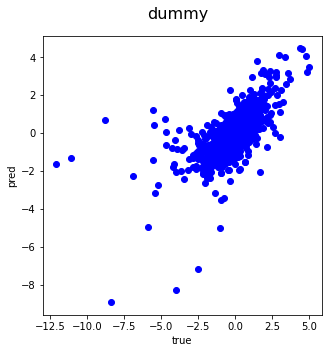

In [141]:
 tmp_mse, tmp_r2 = model_eval(model_dict['linear'], key, X_train, X_test, y_train, y_test)

fold=0
Mean squared error: 0.6584
Coefficient of determination: -0.0336


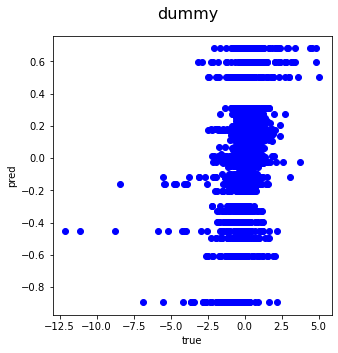

Mean squared error: 0.4243
Coefficient of determination: 0.4074


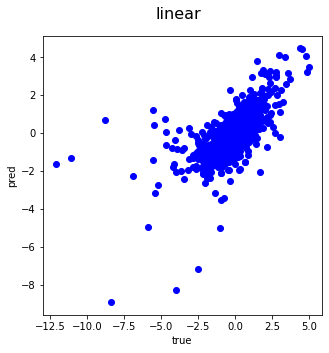

Mean squared error: 0.6270
Coefficient of determination: -0.0159


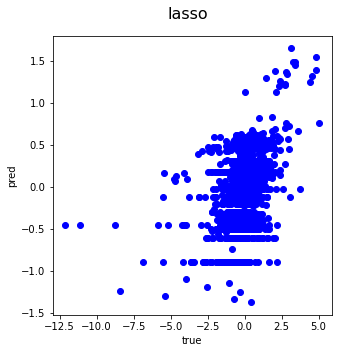

Mean squared error: 0.5865
Coefficient of determination: 0.0266


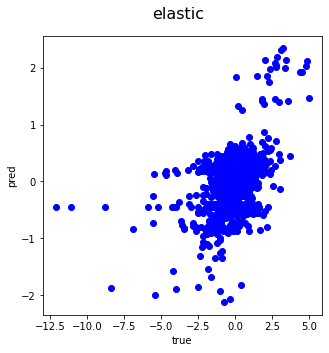

Mean squared error: 0.4239
Coefficient of determination: 0.4089


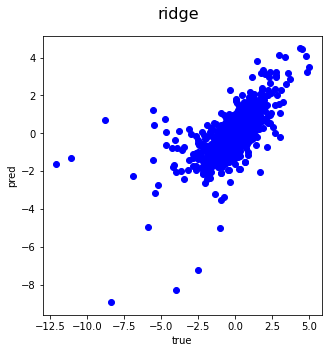

Mean squared error: 0.4420
Coefficient of determination: 0.4203


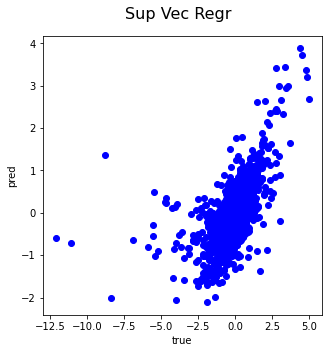

Mean squared error: 0.4257
Coefficient of determination: 0.3898


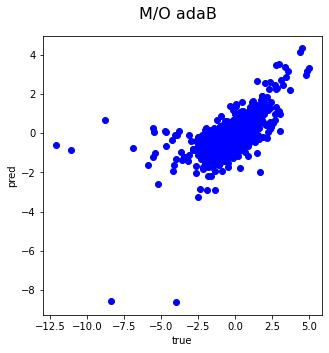

Mean squared error: 0.4045
Coefficient of determination: 0.3964


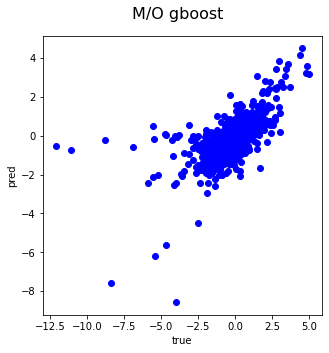

Mean squared error: 0.4113
Coefficient of determination: 0.3875


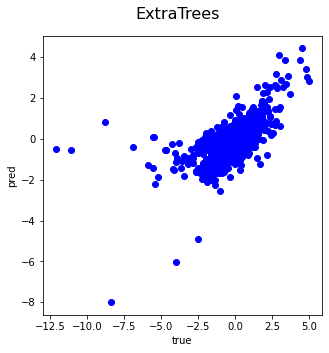

Mean squared error: 0.4457
Coefficient of determination: 0.3380


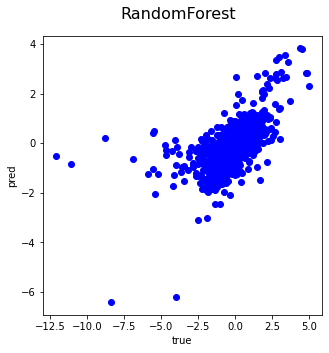

fold=1
Mean squared error: 0.6338
Coefficient of determination: -0.0270


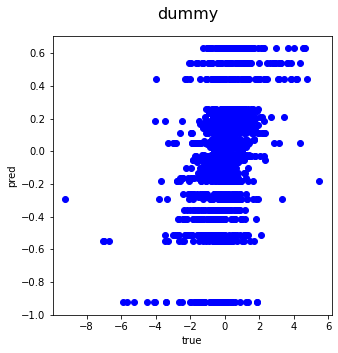

Mean squared error: 0.4037
Coefficient of determination: 0.4030


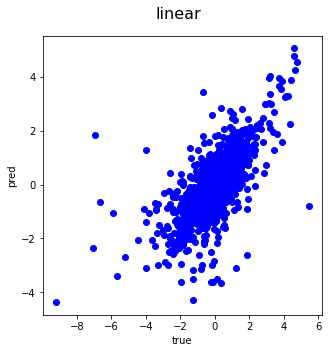

Mean squared error: 0.6014
Coefficient of determination: -0.0122


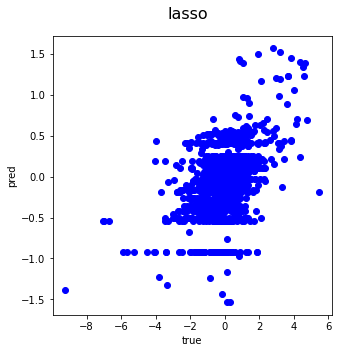

Mean squared error: 0.5642
Coefficient of determination: 0.0187


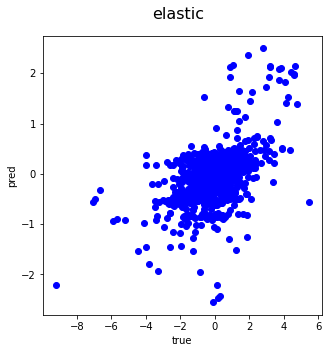

Mean squared error: 0.4020
Coefficient of determination: 0.4057


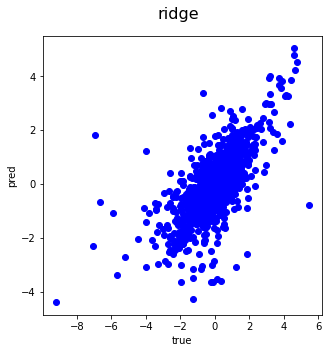

Mean squared error: 0.3950
Coefficient of determination: 0.3858


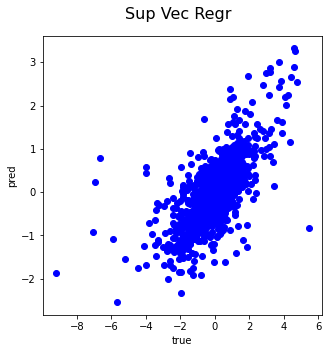

Mean squared error: 0.3776
Coefficient of determination: 0.3848


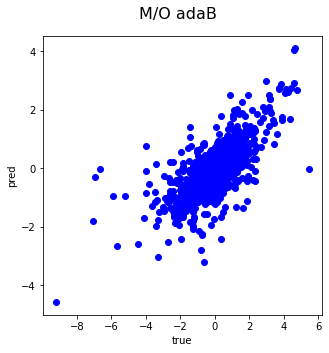

Mean squared error: 0.3907
Coefficient of determination: 0.3781


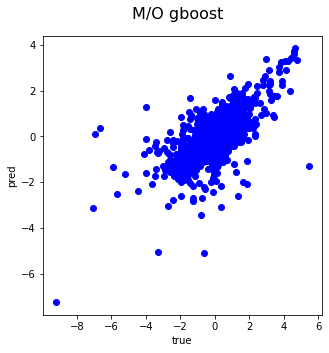

Mean squared error: 0.4000
Coefficient of determination: 0.3572


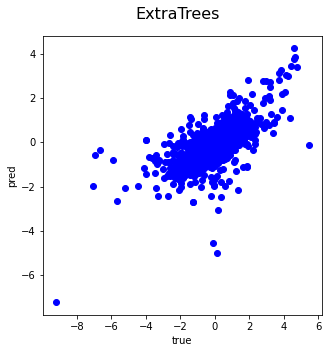

Mean squared error: 0.4179
Coefficient of determination: 0.3248


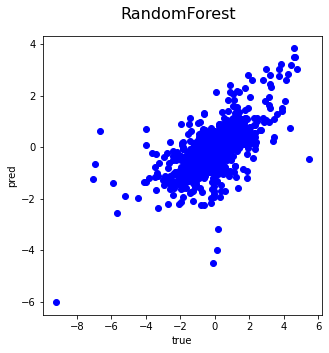

fold=2
Mean squared error: 0.5939
Coefficient of determination: -0.0238


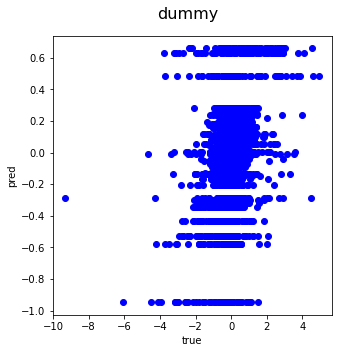

Mean squared error: 0.3908
Coefficient of determination: 0.3477


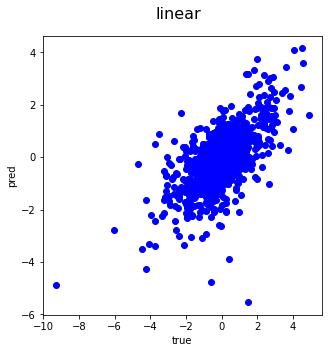

Mean squared error: 0.5694
Coefficient of determination: -0.0133


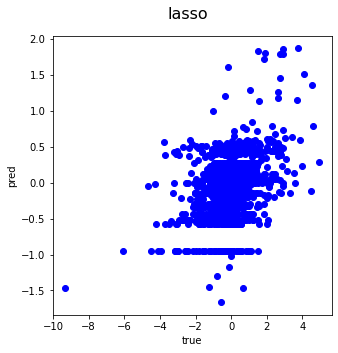

Mean squared error: 0.5462
Coefficient of determination: 0.0132


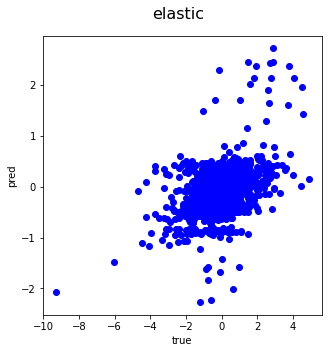

Mean squared error: 0.3887
Coefficient of determination: 0.3504


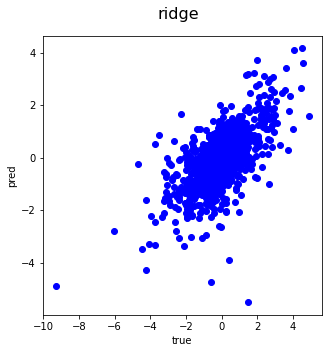

Mean squared error: 0.3953
Coefficient of determination: 0.3258


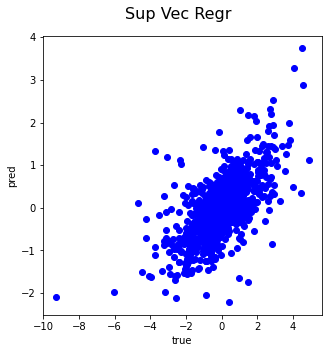

Mean squared error: 0.4131
Coefficient of determination: 0.2949


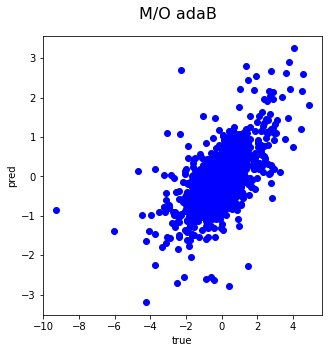

Mean squared error: 0.4055
Coefficient of determination: 0.3121


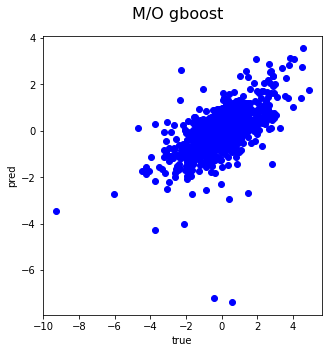

Mean squared error: 0.3962
Coefficient of determination: 0.2927


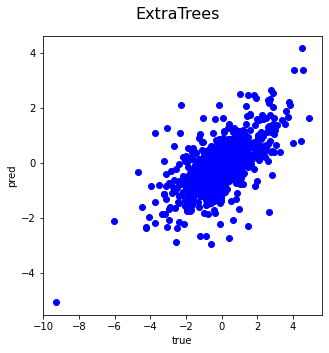

Mean squared error: 0.4192
Coefficient of determination: 0.2663


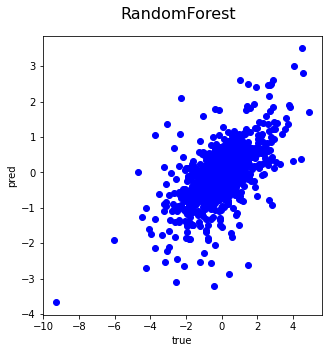

fold=3
Mean squared error: 0.5944
Coefficient of determination: -0.0360


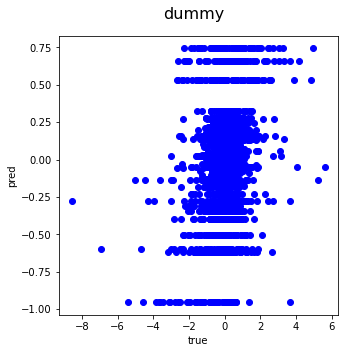

Mean squared error: 0.3361
Coefficient of determination: 0.4124


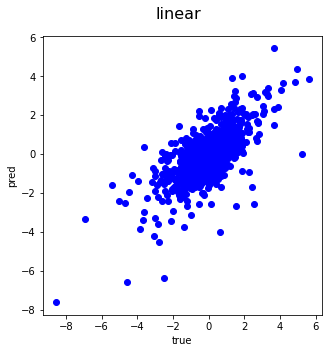

Mean squared error: 0.5606
Coefficient of determination: -0.0200


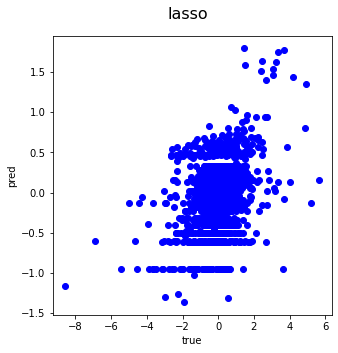

Mean squared error: 0.5231
Coefficient of determination: 0.0163


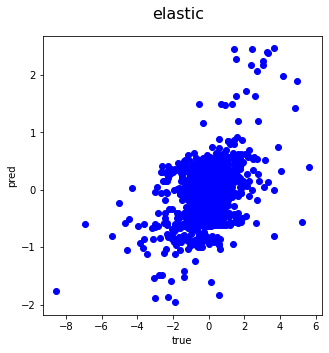

Mean squared error: 0.3348
Coefficient of determination: 0.4145


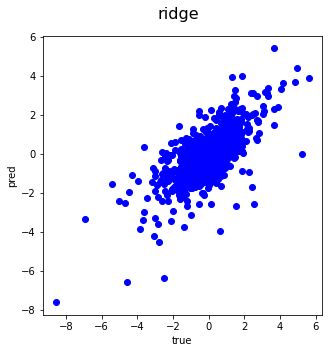

Mean squared error: 0.3578
Coefficient of determination: 0.3593


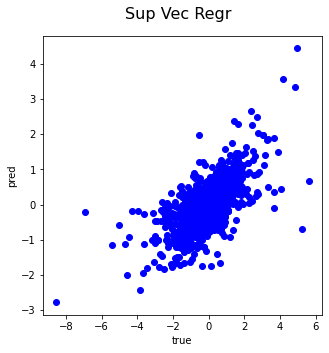

Mean squared error: 0.3453
Coefficient of determination: 0.3648


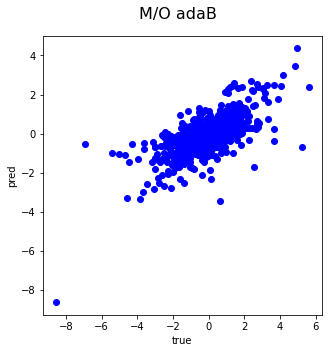

Mean squared error: 0.3417
Coefficient of determination: 0.3820


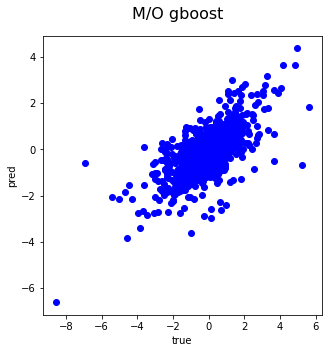

Mean squared error: 0.3448
Coefficient of determination: 0.3515


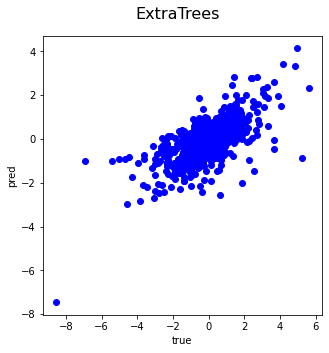

Mean squared error: 0.3596
Coefficient of determination: 0.3181


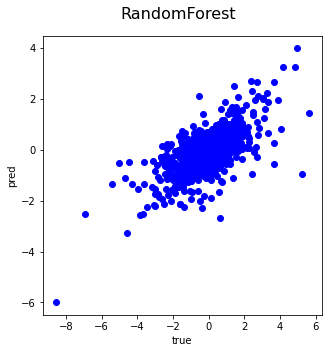

fold=4
Mean squared error: 0.5751
Coefficient of determination: -0.0268


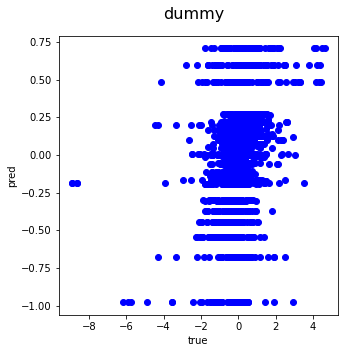

Mean squared error: 0.3554
Coefficient of determination: 0.4444


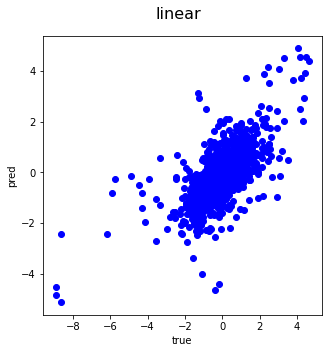

Mean squared error: 0.5468
Coefficient of determination: -0.0140


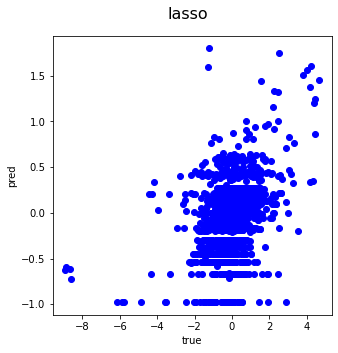

Mean squared error: 0.5057
Coefficient of determination: 0.0249


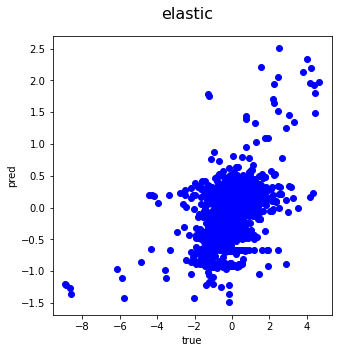

Mean squared error: 0.3540
Coefficient of determination: 0.4471


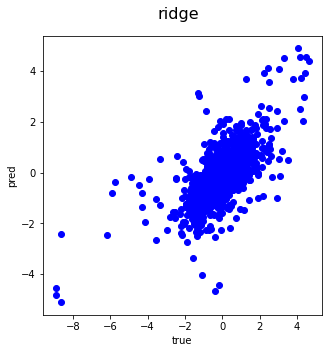

Mean squared error: 0.3379
Coefficient of determination: 0.4338


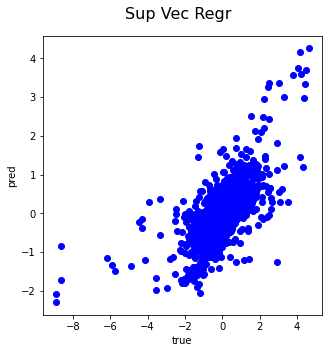

Mean squared error: 0.3582
Coefficient of determination: 0.3904


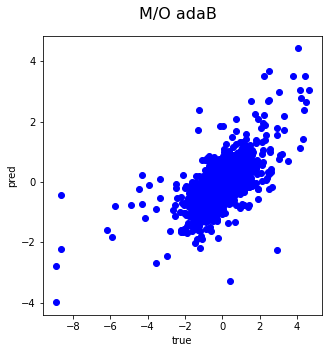

Mean squared error: 0.3050
Coefficient of determination: 0.4350


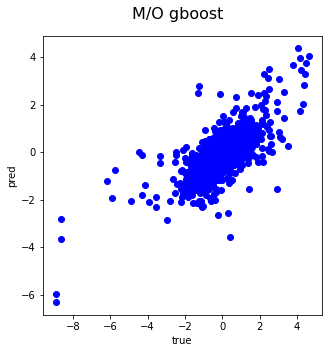

Mean squared error: 0.3472
Coefficient of determination: 0.3935


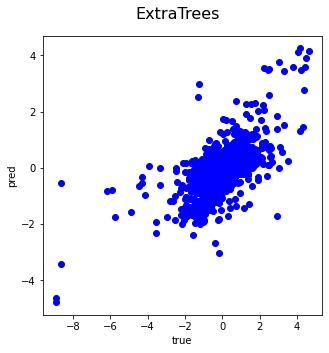

Mean squared error: 0.3678
Coefficient of determination: 0.3517


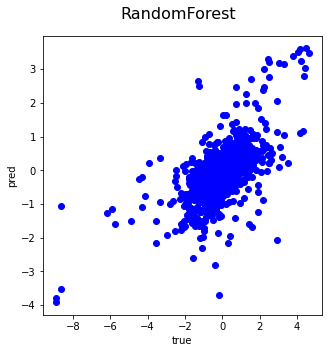

In [145]:
fold=0
mse = defaultdict(list)
r2 = defaultdict(list)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(range(len(pro_train_all))):
    print('fold='+str(fold))
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.asarray(pro_train_all)[train_index], np.asarray(pro_train_all)[test_index]
    y_train, y_test = np.asarray(lip_train_all)[train_index], np.asarray(lip_train_all)[test_index]
    for key in model_dict.keys():
        tmp_mse, tmp_r2 = model_eval(model_dict[key], key, X_train, X_test, y_train, y_test)
        mse[key].append(tmp_mse)
        r2[key].append(tmp_r2)
    fold+=1

In [146]:
mse_means = []
r2_means = []
for key in mse.keys():
    print(key)
    print('MSE= '+ str(np.mean(mse[key])) +'+/-' + str(np.std(mse[key])))
    mse_means.append(np.mean(mse[key]))
    print('Rsq= '+ str(np.mean(r2[key])) +'+/-' + str(np.std(r2[key])) )
    r2_means.append(np.mean(r2[key]))

dummy
MSE= 0.6111134017835487+/-0.030393856032885913
Rsq= -0.029440653851106374+/-0.004572936173445976
linear
MSE= 0.38205705271611085+/-0.03206182447482036
Rsq= 0.4029864456335914+/-0.03123293722186412
lasso
MSE= 0.5810413911590049+/-0.029182173983850812
Rsq= -0.015092346588276326+/-0.002742952459117627
elastic
MSE= 0.545139207478772+/-0.02871649312480229
Rsq= 0.01992287706517511+/-0.005101301155482274
ridge
MSE= 0.38068590083727644+/-0.03224551808361147
Rsq= 0.40531965385950774+/-0.031161789393047777
Sup Vec Regr
MSE= 0.3855960278398012+/-0.035807729962588936
Rsq= 0.3849866470934956+/-0.0394853816003686
M/O adaB
MSE= 0.38399590580196774+/-0.030935747517342235
Rsq= 0.3649450141840415+/-0.036254990591991054
M/O gboost
MSE= 0.36948975499401776+/-0.03975974361801663
Rsq= 0.38072577210627406+/-0.039768629974602114
ExtraTrees
MSE= 0.37989268138629706+/-0.02812682902250362
Rsq= 0.35647432309549076+/-0.03584850731892293
RandomForest
MSE= 0.402041925431398+/-0.032937476288530845
Rsq= 0.319766

In [147]:
### get numpy array from values
#y = np.zeros(len(mse))
mse_arr = np.zeros((len(mse), 5))
i = 0
for key, values in mse.items():
    #y[i] = key
    mse_arr[i, :] = values
    i += 1
    
r2_arr = np.zeros((len(r2), 5))
i = 0
for key, values in r2.items():
    #y[i] = key
    r2_arr[i, :] = values
    i += 1
mse_hm = np.c_[mse_arr, mse_means]
r2_hm = np.c_[r2_arr, r2_means]

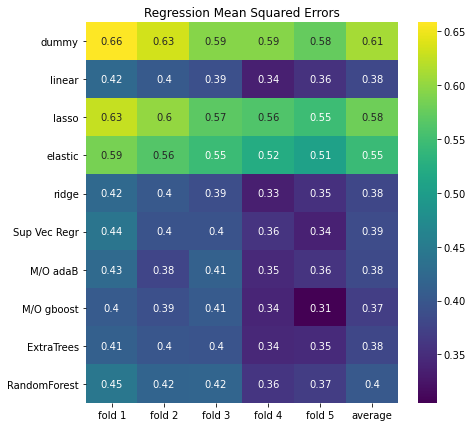

In [148]:
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(mse_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression Mean Squared Errors')
plt.savefig('MSE_yeast_lipids_hm.svg')

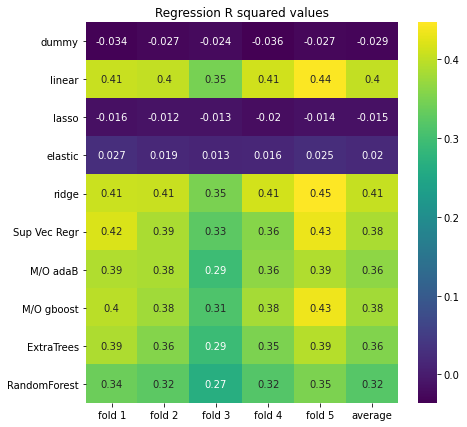

In [149]:
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(r2_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression R squared values')
plt.savefig('r2_yeast_lipids_hm.svg')

# Now metabolite data

fold=0
Mean squared error: 0.1022
Coefficient of determination: -0.0115


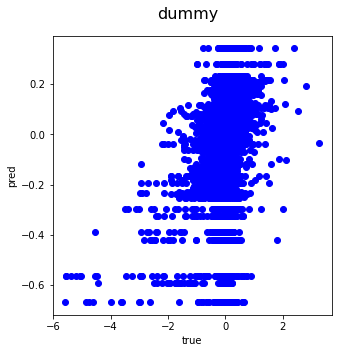

Mean squared error: 0.0437
Coefficient of determination: 0.2783


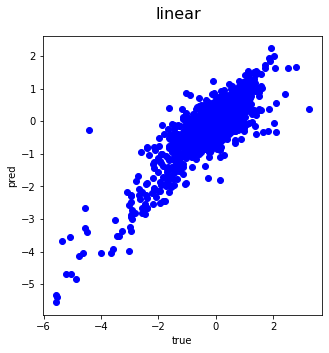

Mean squared error: 0.0818
Coefficient of determination: 0.0007


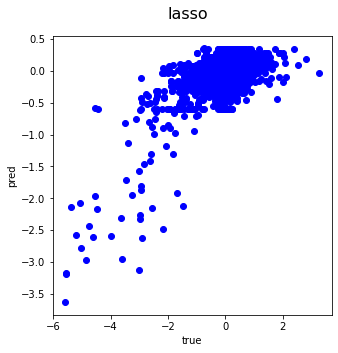

Mean squared error: 0.0711
Coefficient of determination: 0.0157


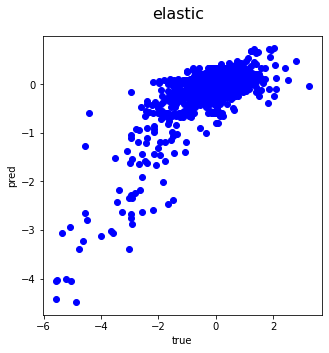

Mean squared error: 0.0436
Coefficient of determination: 0.2818


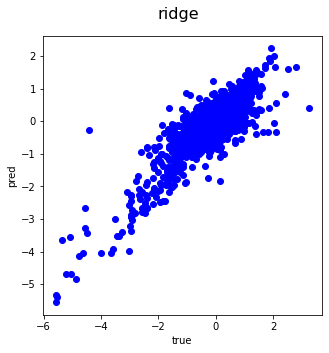

Mean squared error: 0.0425
Coefficient of determination: 0.3591


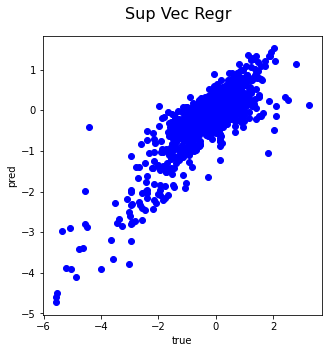

Mean squared error: 0.0444
Coefficient of determination: 0.3495


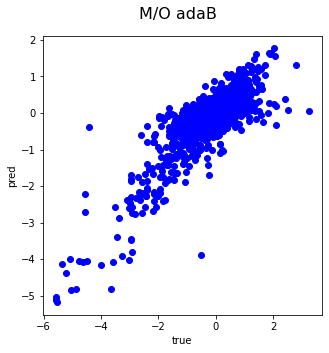

Mean squared error: 0.0427
Coefficient of determination: 0.3555


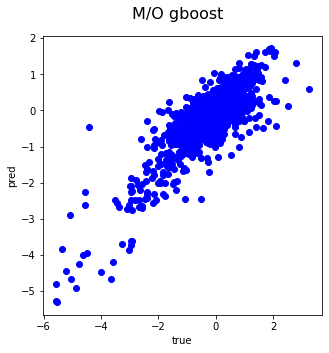

Mean squared error: 0.0425
Coefficient of determination: 0.3704


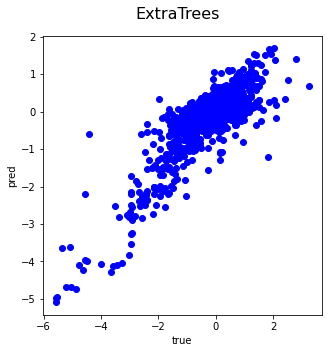

Mean squared error: 0.0433
Coefficient of determination: 0.3624


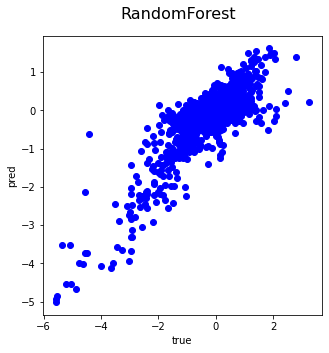

fold=1
Mean squared error: 0.1322
Coefficient of determination: -0.0309


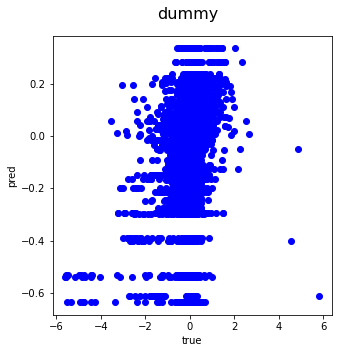

Mean squared error: 0.0609
Coefficient of determination: 0.2425


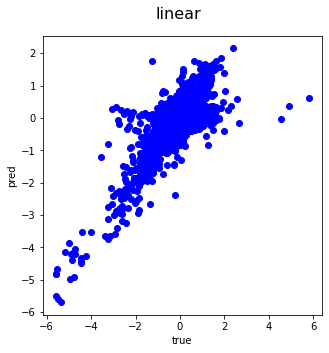

Mean squared error: 0.1066
Coefficient of determination: -0.0191


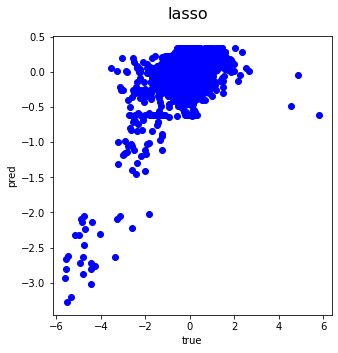

Mean squared error: 0.0930
Coefficient of determination: -0.0036


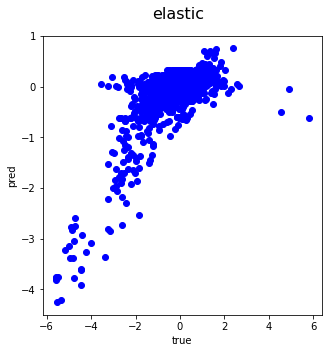

Mean squared error: 0.0608
Coefficient of determination: 0.2452


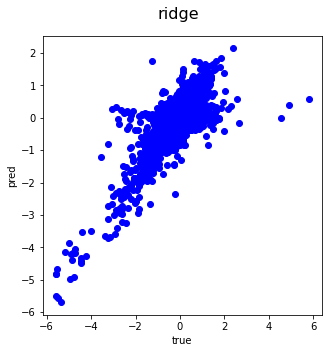

Mean squared error: 0.0624
Coefficient of determination: 0.2977


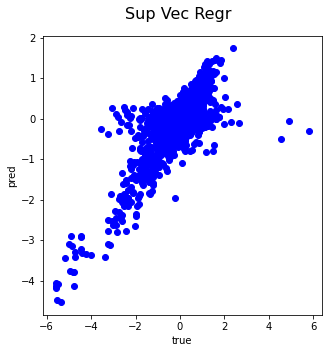

Mean squared error: 0.0641
Coefficient of determination: 0.3106


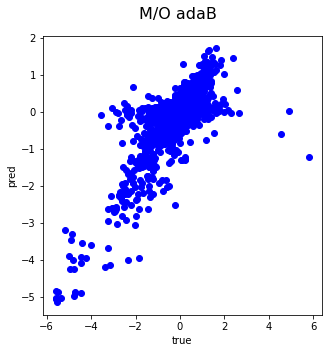

Mean squared error: 0.0621
Coefficient of determination: 0.3003


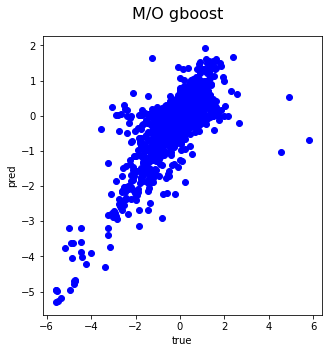

Mean squared error: 0.0610
Coefficient of determination: 0.3123


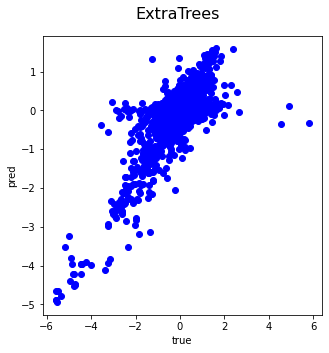

Mean squared error: 0.0650
Coefficient of determination: 0.2777


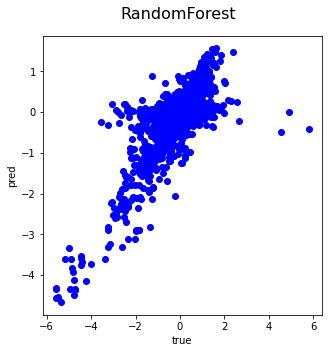

fold=2
Mean squared error: 0.1214
Coefficient of determination: -0.0209


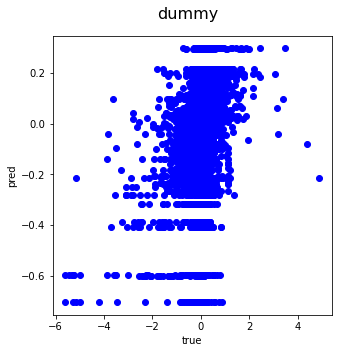

Mean squared error: 0.0661
Coefficient of determination: 0.1765


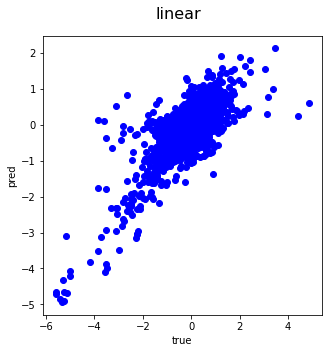

Mean squared error: 0.1015
Coefficient of determination: -0.0081


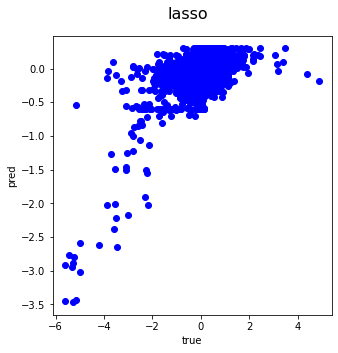

Mean squared error: 0.0924
Coefficient of determination: 0.0049


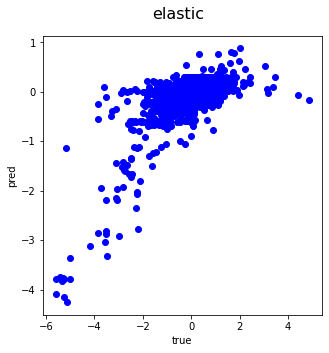

Mean squared error: 0.0660
Coefficient of determination: 0.1793


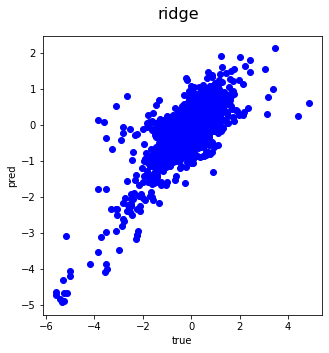

Mean squared error: 0.0697
Coefficient of determination: 0.2324


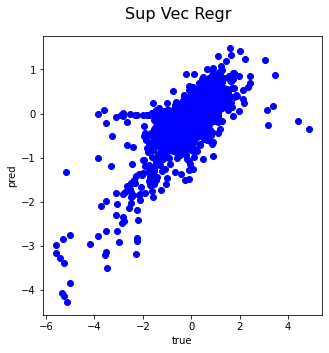

Mean squared error: 0.0685
Coefficient of determination: 0.2397


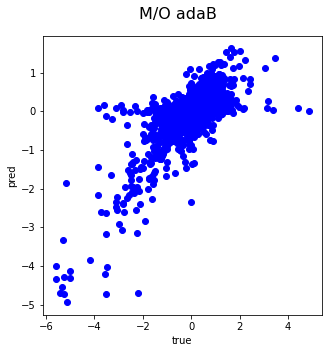

Mean squared error: 0.0686
Coefficient of determination: 0.2422


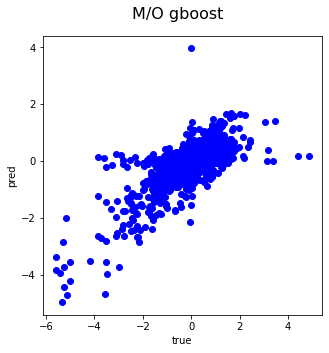

Mean squared error: 0.0695
Coefficient of determination: 0.2308


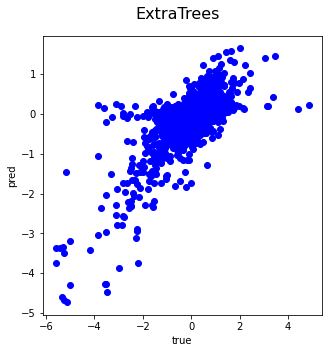

Mean squared error: 0.0737
Coefficient of determination: 0.2127


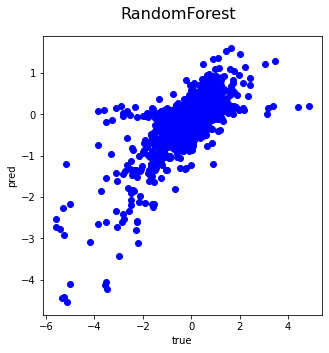

fold=3
Mean squared error: 0.1129
Coefficient of determination: -0.0144


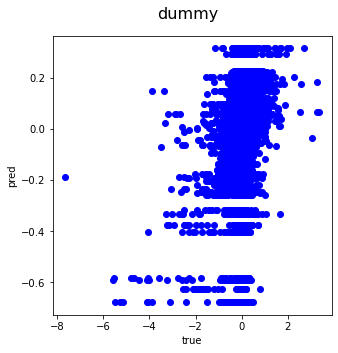

Mean squared error: 0.0500
Coefficient of determination: 0.2663


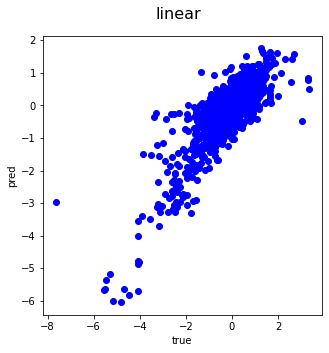

Mean squared error: 0.0935
Coefficient of determination: -0.0015


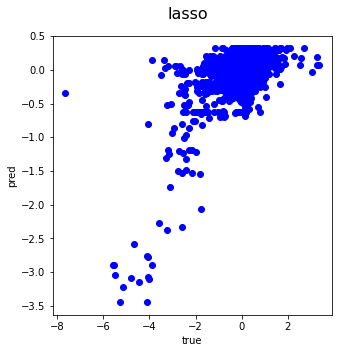

Mean squared error: 0.0836
Coefficient of determination: 0.0136


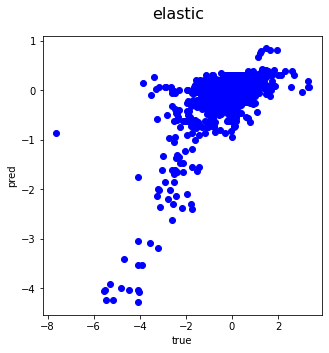

Mean squared error: 0.0499
Coefficient of determination: 0.2692


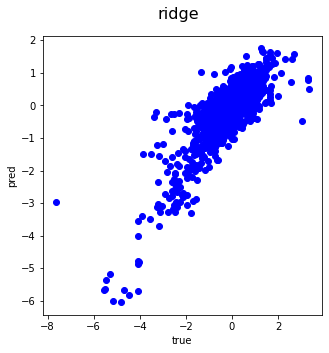

Mean squared error: 0.0558
Coefficient of determination: 0.2895


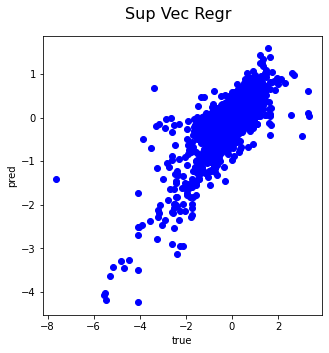

Mean squared error: 0.0552
Coefficient of determination: 0.2975


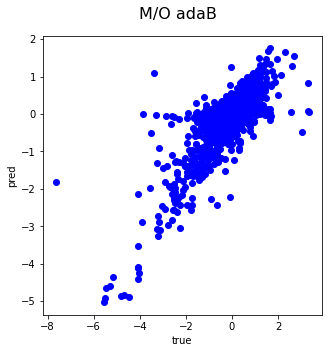

Mean squared error: 0.0537
Coefficient of determination: 0.2679


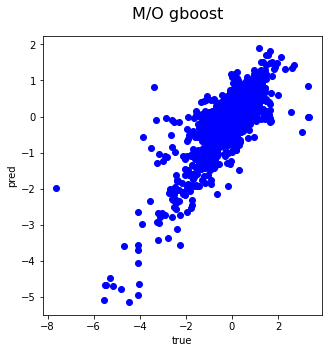

Mean squared error: 0.0528
Coefficient of determination: 0.2979


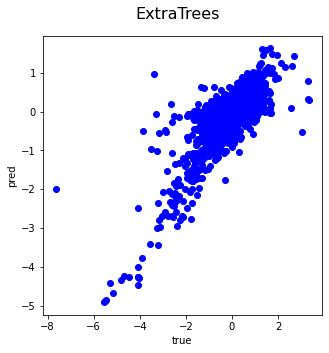

Mean squared error: 0.0557
Coefficient of determination: 0.2920


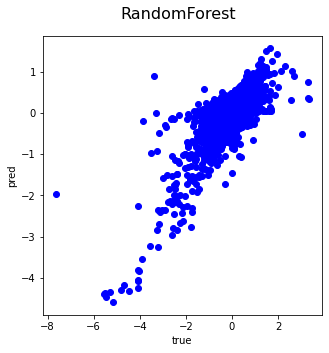

fold=4
Mean squared error: 0.0981
Coefficient of determination: -0.0204


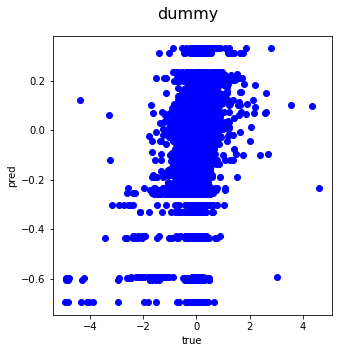

Mean squared error: 0.0523
Coefficient of determination: 0.2072


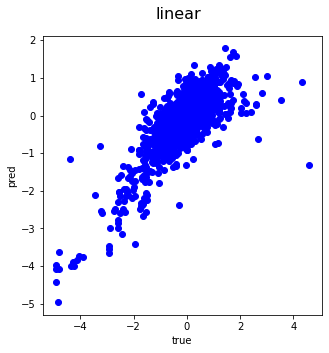

Mean squared error: 0.0816
Coefficient of determination: -0.0066


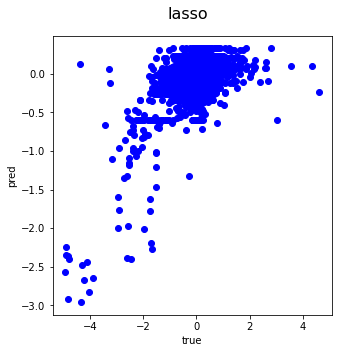

Mean squared error: 0.0757
Coefficient of determination: 0.0070


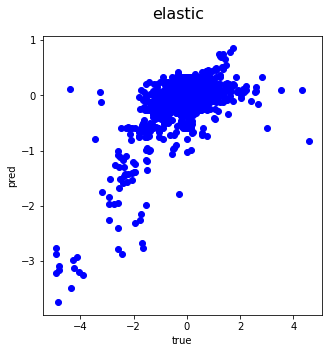

Mean squared error: 0.0524
Coefficient of determination: 0.2099


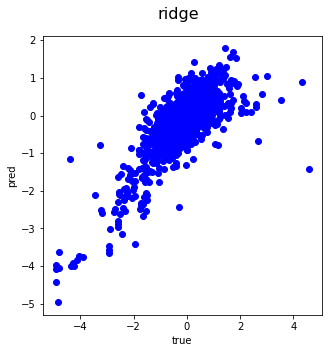

Mean squared error: 0.0519
Coefficient of determination: 0.2782


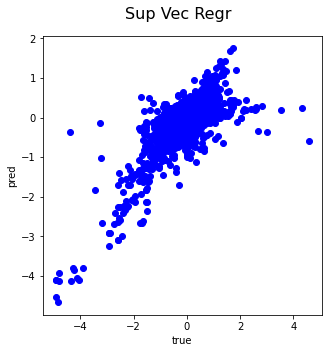

Mean squared error: 0.0547
Coefficient of determination: 0.2656


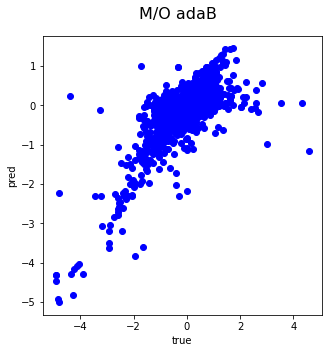

Mean squared error: 0.0546
Coefficient of determination: 0.2403


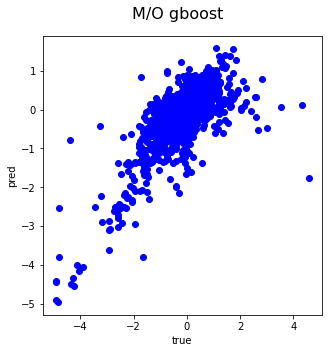

Mean squared error: 0.0518
Coefficient of determination: 0.2732


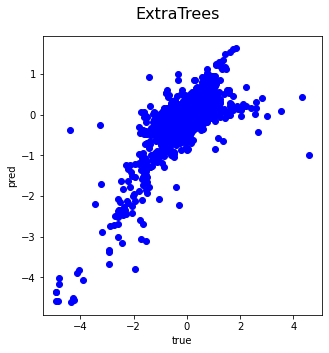

Mean squared error: 0.0526
Coefficient of determination: 0.2678


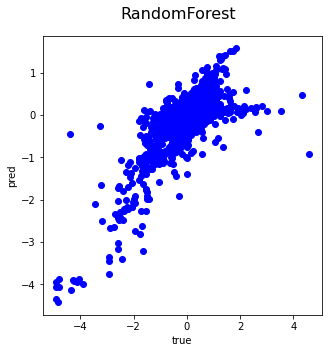

In [50]:
fold=0
mse = defaultdict(list)
r2 = defaultdict(list)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(range(len(pro_train_all))):
    print('fold='+str(fold))
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.asarray(pro_train_all)[train_index], np.asarray(pro_train_all)[test_index]
    y_train, y_test = np.asarray(met_train_all)[train_index], np.asarray(met_train_all)[test_index]
    for key in model_dict.keys():
        tmp_mse, tmp_r2 = model_eval(model_dict[key], key, X_train, X_test, y_train, y_test)
        mse[key].append(tmp_mse)
        r2[key].append(tmp_r2)
    fold+=1

In [51]:
mse_means = []
r2_means = []
for key in mse.keys():
    print(key)
    print('MSE= '+ str(np.mean(mse[key])) +'+/-' + str(np.std(mse[key])))
    mse_means.append(np.mean(mse[key]))
    print('Rsq= '+ str(np.mean(r2[key])) +'+/-' + str(np.std(r2[key])) )
    r2_means.append(np.mean(r2[key]))

dummy
MSE= 0.11335333423397889+/-0.01247389928481047
Rsq= -0.019610947892185128+/-0.00668520813548824
linear
MSE= 0.05462608819200034+/-0.007960666665292467
Rsq= 0.23417893046043084+/-0.03768199443977419
lasso
MSE= 0.0930245395100841+/-0.010120150940507971
Rsq= -0.006924595417140836+/-0.006890355545705236
elastic
MSE= 0.08315674365450025+/-0.008749348845825514
Rsq= 0.007510013460738823+/-0.006827569017466188
ridge
MSE= 0.054521977779175834+/-0.007942535726905698
Rsq= 0.2370885109455077+/-0.03789613809626191
Sup Vec Regr
MSE= 0.056482818308481786+/-0.00924018539288303
Rsq= 0.29137994078865886+/-0.0406800180924757
M/O adaB
MSE= 0.05736770330445331+/-0.008352252899663968
Rsq= 0.2925808167370586+/-0.03770174053806193
M/O gboost
MSE= 0.05632031683305091+/-0.008708781513776463
Rsq= 0.28124116843923996+/-0.043037006921641294
ExtraTrees
MSE= 0.055541610982598064+/-0.00911862311352806
Rsq= 0.2969312009793272+/-0.04600366988065311
RandomForest
MSE= 0.05804828854036429+/-0.010444483882424206
Rsq=

In [52]:
### get numpy array from values
#y = np.zeros(len(mse))
mse_arr = np.zeros((len(mse), 5))
i = 0
for key, values in mse.items():
    #y[i] = key
    mse_arr[i, :] = values
    i += 1
    
r2_arr = np.zeros((len(r2), 5))
i = 0
for key, values in r2.items():
    #y[i] = key
    r2_arr[i, :] = values
    i += 1
mse_hm = np.c_[mse_arr, mse_means]
r2_hm = np.c_[r2_arr, r2_means]

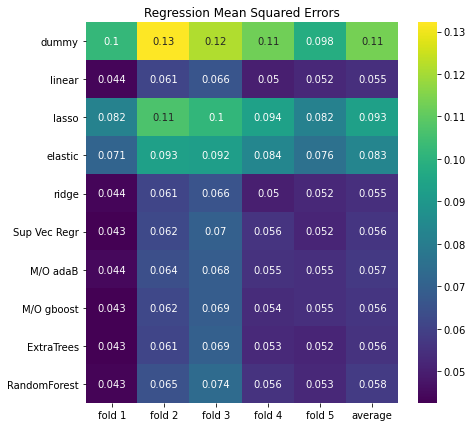

In [53]:
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(mse_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression Mean Squared Errors')
plt.savefig('MSE_yeast_metabolites_hm.svg')

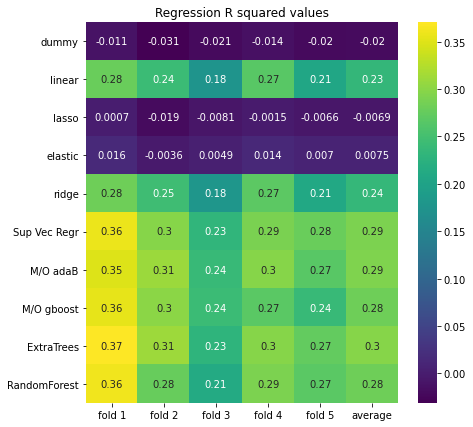

In [54]:
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(r2_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression R squared values')
plt.savefig('r2_yeast_metabolites_hm.svg')

# combined lipid/metabolite output


fold=0
Mean squared error: 0.1940
Coefficient of determination: -0.0151


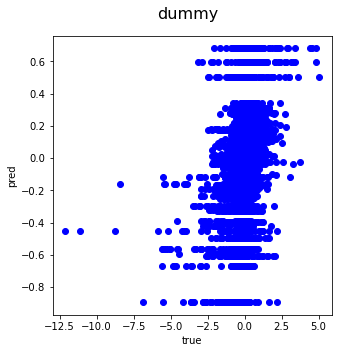

Mean squared error: 0.1066
Coefficient of determination: 0.2996


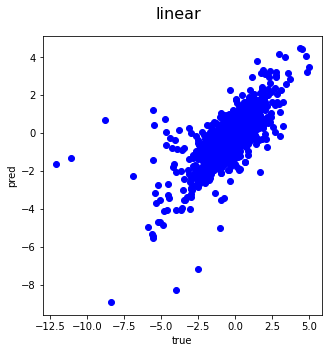

Mean squared error: 0.1719
Coefficient of determination: -0.0020


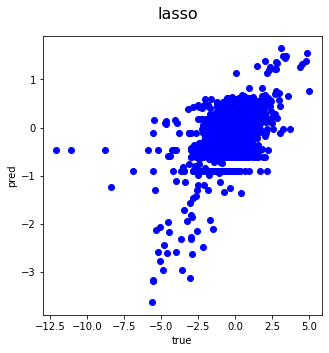

Mean squared error: 0.1562
Coefficient of determination: 0.0175


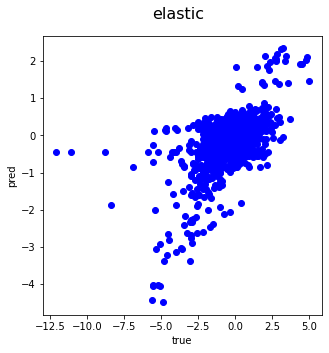

Mean squared error: 0.1064
Coefficient of determination: 0.3028


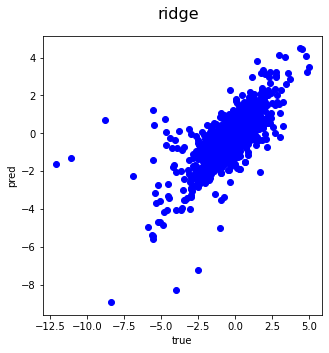

Mean squared error: 0.1085
Coefficient of determination: 0.3692


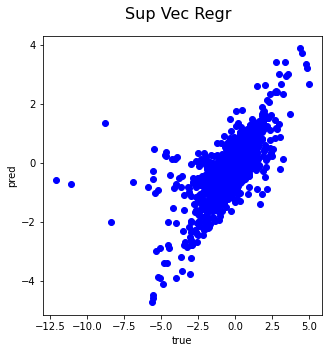

Mean squared error: 0.1028
Coefficient of determination: 0.3864


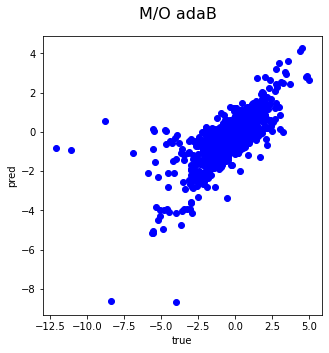

Mean squared error: 0.1030
Coefficient of determination: 0.3630


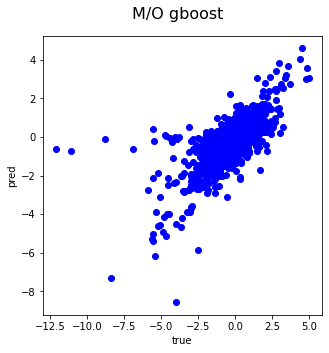

Mean squared error: 0.1053
Coefficient of determination: 0.3754


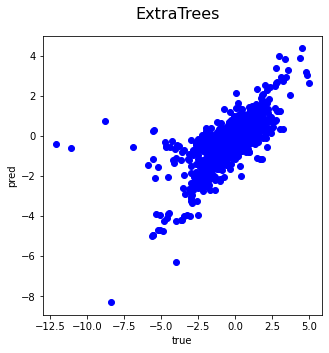

Mean squared error: 0.1105
Coefficient of determination: 0.3418


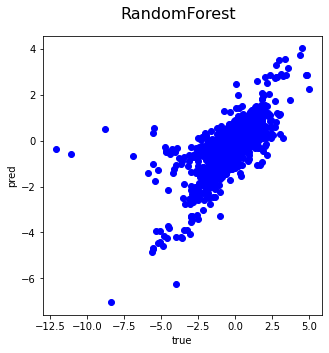

fold=1
Mean squared error: 0.2150
Coefficient of determination: -0.0303


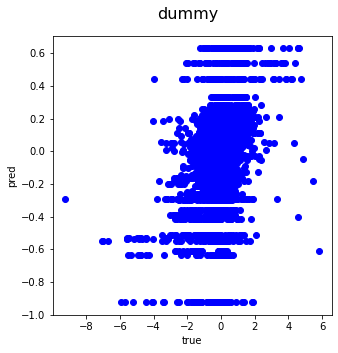

Mean squared error: 0.1175
Coefficient of determination: 0.2690


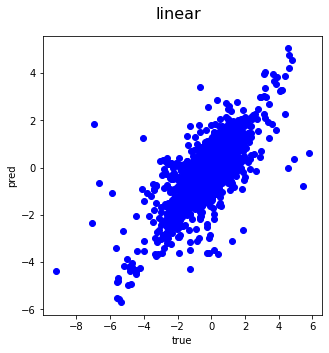

Mean squared error: 0.1883
Coefficient of determination: -0.0180


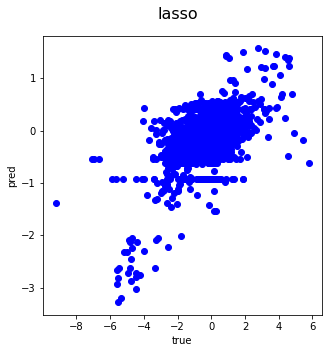

Mean squared error: 0.1708
Coefficient of determination: 0.0001


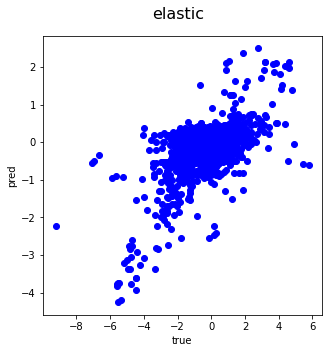

Mean squared error: 0.1171
Coefficient of determination: 0.2717


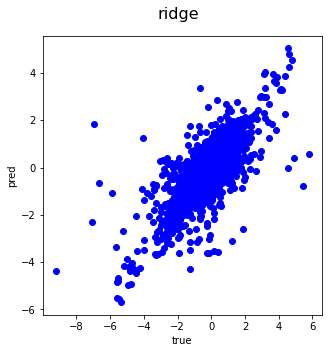

Mean squared error: 0.1173
Coefficient of determination: 0.3122


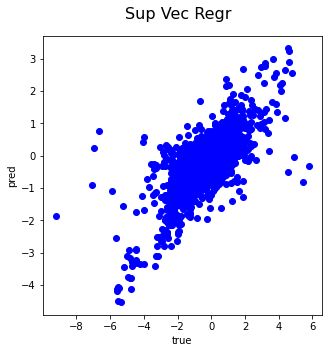

Mean squared error: 0.1118
Coefficient of determination: 0.3434


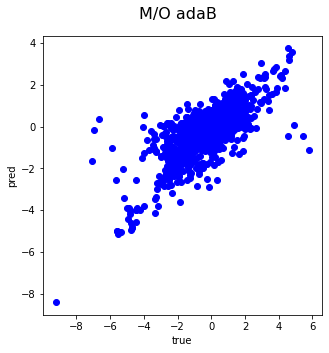

Mean squared error: 0.1166
Coefficient of determination: 0.3051


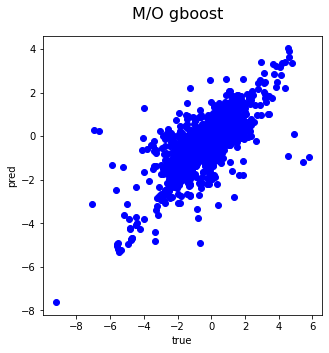

Mean squared error: 0.1158
Coefficient of determination: 0.3269


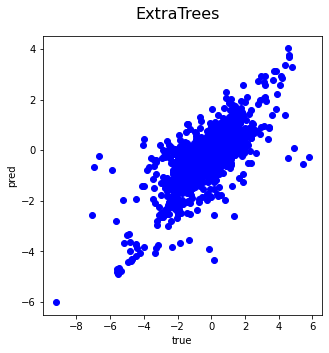

Mean squared error: 0.1214
Coefficient of determination: 0.3014


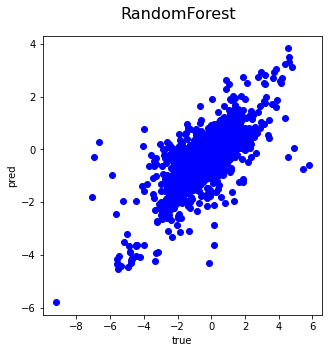

fold=2
Mean squared error: 0.1995
Coefficient of determination: -0.0214


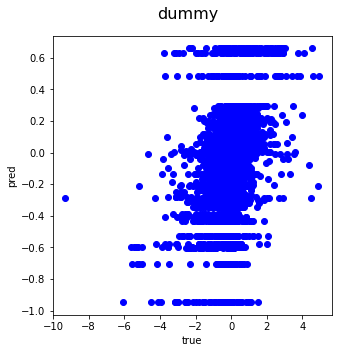

Mean squared error: 0.1197
Coefficient of determination: 0.2048


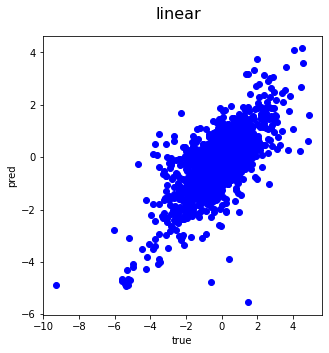

Mean squared error: 0.1788
Coefficient of determination: -0.0089


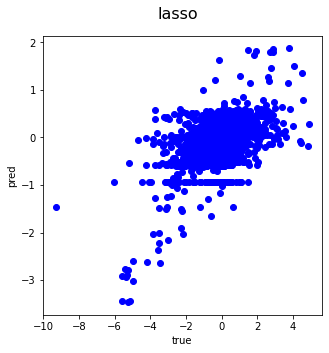

Mean squared error: 0.1673
Coefficient of determination: 0.0063


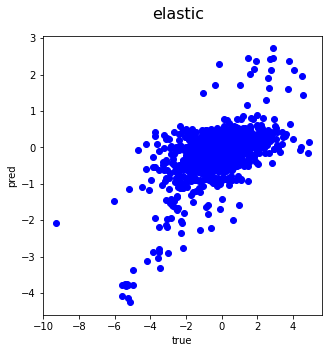

Mean squared error: 0.1193
Coefficient of determination: 0.2075


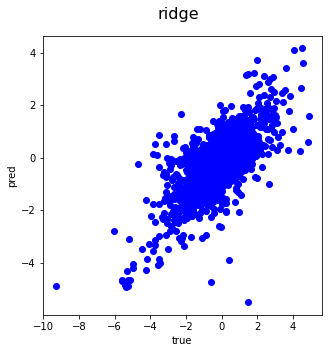

Mean squared error: 0.1235
Coefficient of determination: 0.2478


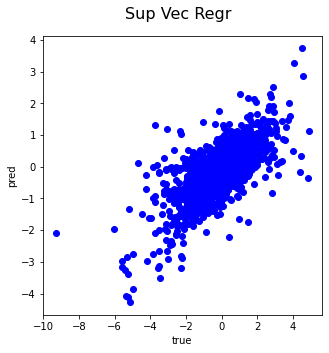

Mean squared error: 0.1214
Coefficient of determination: 0.2744


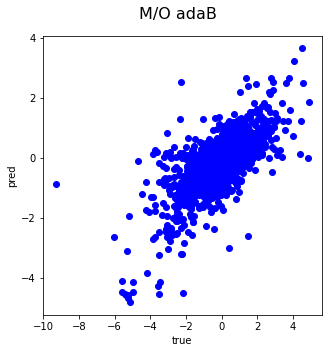

Mean squared error: 0.1265
Coefficient of determination: 0.2508


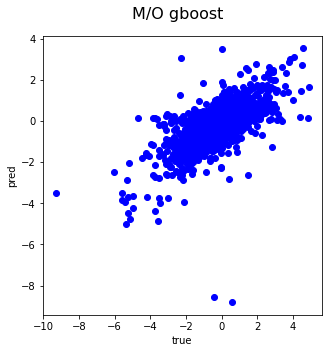

Mean squared error: 0.1245
Coefficient of determination: 0.2550


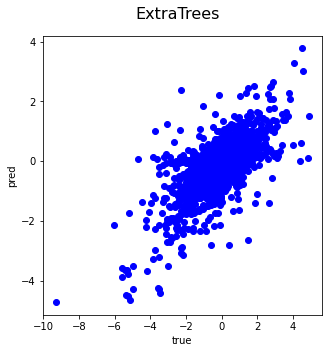

Mean squared error: 0.1329
Coefficient of determination: 0.2247


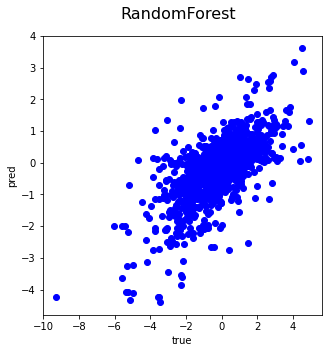

fold=3
Mean squared error: 0.1924
Coefficient of determination: -0.0180


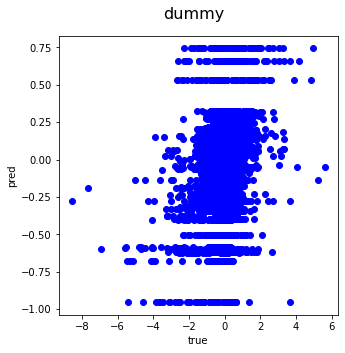

Mean squared error: 0.0973
Coefficient of determination: 0.2904


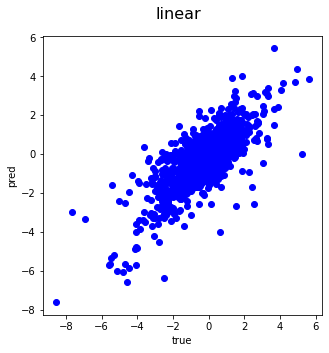

Mean squared error: 0.1707
Coefficient of determination: -0.0046


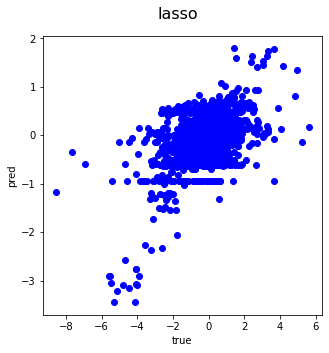

Mean squared error: 0.1562
Coefficient of determination: 0.0140


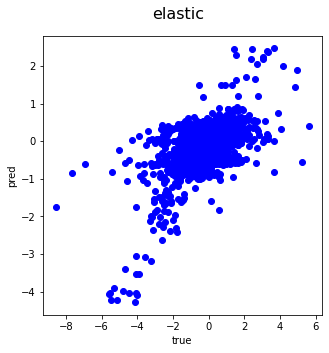

Mean squared error: 0.0970
Coefficient of determination: 0.2932


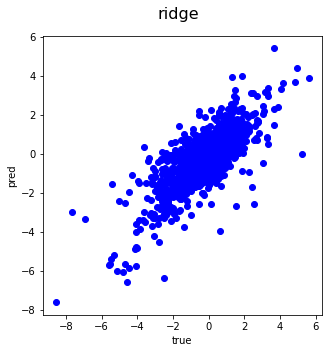

Mean squared error: 0.1057
Coefficient of determination: 0.3010


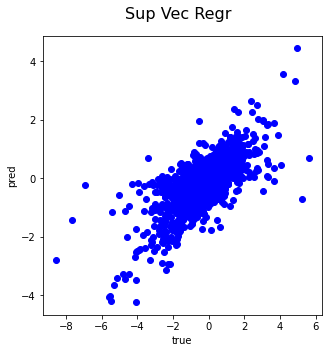

Mean squared error: 0.0980
Coefficient of determination: 0.3401


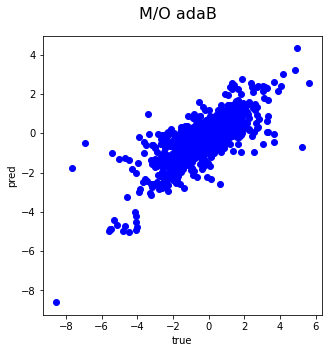

Mean squared error: 0.0997
Coefficient of determination: 0.2915


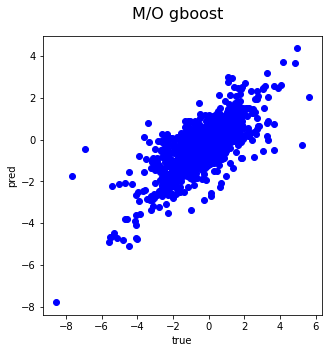

Mean squared error: 0.0997
Coefficient of determination: 0.3267


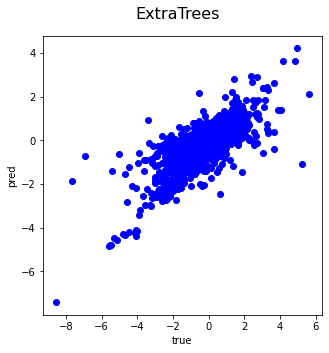

Mean squared error: 0.1051
Coefficient of determination: 0.3012


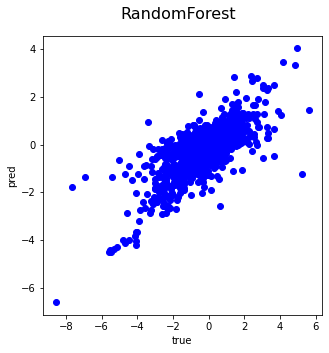

fold=4
Mean squared error: 0.1768
Coefficient of determination: -0.0214


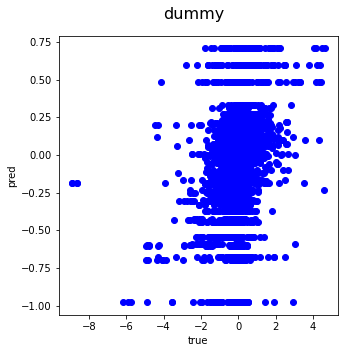

Mean squared error: 0.1024
Coefficient of determination: 0.2464


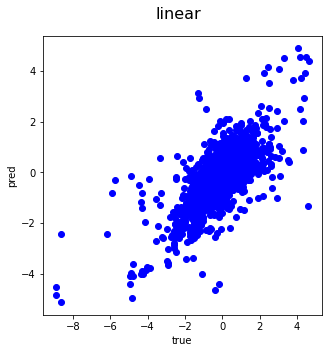

Mean squared error: 0.1584
Coefficient of determination: -0.0078


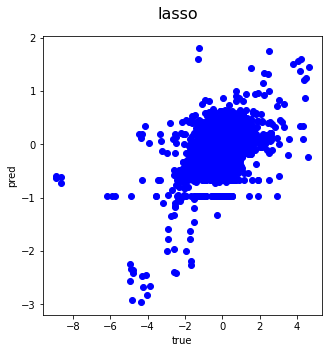

Mean squared error: 0.1467
Coefficient of determination: 0.0100


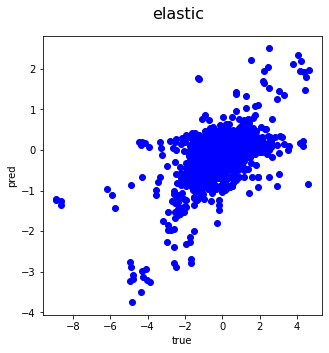

Mean squared error: 0.1022
Coefficient of determination: 0.2491


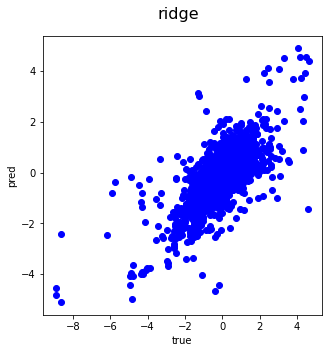

Mean squared error: 0.0991
Coefficient of determination: 0.3039


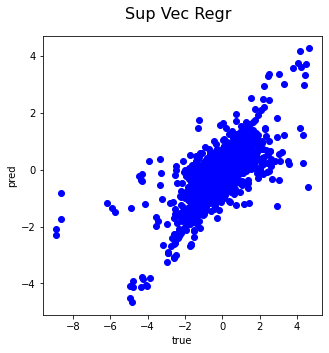

Mean squared error: 0.1004
Coefficient of determination: 0.3136


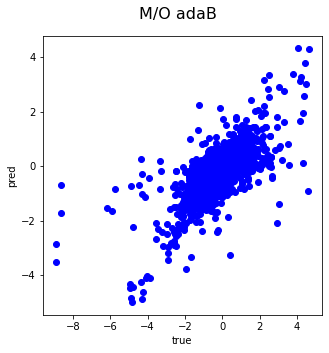

Mean squared error: 0.0950
Coefficient of determination: 0.2768


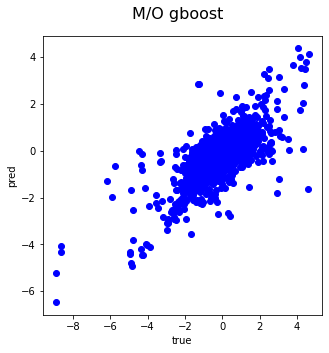

Mean squared error: 0.1017
Coefficient of determination: 0.2897


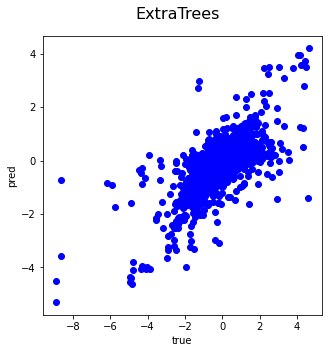

Mean squared error: 0.1068
Coefficient of determination: 0.2607


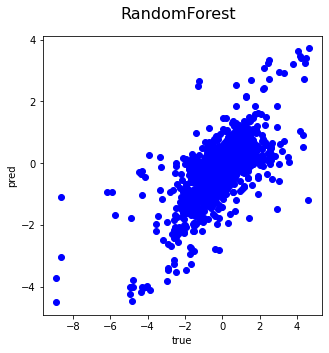

In [55]:
model_dict = {
    'dummy': DummyRegressor(),
    'linear': LinearRegression(),
    'lasso' : Lasso(),
    'elastic': ElasticNet(),
    'ridge': Ridge(),
    'Sup Vec Regr': MultiOutputRegressor(SVR()),
    'M/O adaB': MultiOutputRegressor(AdaBoostRegressor(n_estimators=500)),
    'M/O gboost': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=500)) , 
    'ExtraTrees': ExtraTreesRegressor(n_estimators=500),
    'RandomForest' : RandomForestRegressor(n_estimators=500)
}

fold=0
mse = defaultdict(list)
r2 = defaultdict(list)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(range(len(pro_train_all))):
    print('fold='+str(fold))
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.asarray(pro_train_all)[train_index], np.asarray(pro_train_all)[test_index]
    y_train, y_test = np.asarray(ml_train_all)[train_index], np.asarray(ml_train_all)[test_index]
    for key in model_dict.keys():
        tmp_mse, tmp_r2 = model_eval(model_dict[key], key, X_train, X_test, y_train, y_test)
        mse[key].append(tmp_mse)
        r2[key].append(tmp_r2)
    fold+=1


In [88]:
model_dict[key].predict(X_test).shape

(62, 327)

In [81]:
mse_means = []
r2_means = []
for key in mse.keys():
    print(key)
    print('MSE= '+ str(np.mean(mse[key])) +'+/-' + str(np.std(mse[key])))
    mse_means.append(np.mean(mse[key]))
    print('Rsq= '+ str(np.mean(r2[key])) +'+/-' + str(np.std(r2[key])) )
    r2_means.append(np.mean(r2[key]))

### get numpy array from values
#y = np.zeros(len(mse))
mse_arr = np.zeros((len(mse), 5))
i = 0
for key, values in mse.items():
    #y[i] = key
    mse_arr[i, :] = values
    i += 1
    
r2_arr = np.zeros((len(r2), 5))
i = 0
for key, values in r2.items():
    #y[i] = key
    r2_arr[i, :] = values
    i += 1
mse_hm = np.c_[mse_arr, mse_means]
r2_hm = np.c_[r2_arr, r2_means]

dummy
MSE= 0.1955522444715225+/-0.012297562877596827
Rsq= -0.021234202087236347+/-0.005097335818639625
linear
MSE= 0.10869881122916145+/-0.008650272635151184
Rsq= 0.26205565829808836+/-0.034024266625559046
lasso
MSE= 0.17361447831449303+/-0.009846841355574693
Rsq= -0.008273398362832935+/-0.00542831331297472
elastic
MSE= 0.1594474257539213+/-0.008661837837057852
Rsq= 0.009559844147709955+/-0.00604936872125477
ridge
MSE= 0.10838391002730255+/-0.008574173947935956
Rsq= 0.26486980060103066+/-0.034134838176486604
Sup Vec Regr
MSE= 0.11083178868980056+/-0.008617035845176466
Rsq= 0.3068379289857878+/-0.038572200880114475
M/O adaB
MSE= 0.106878704321793+/-0.008650857306228195
Rsq= 0.3315602206826648+/-0.03691352067694443
M/O gboost
MSE= 0.10818180277776024+/-0.01165562230753341
Rsq= 0.2974596546953411+/-0.03741713566889959
ExtraTrees
MSE= 0.10939593774457121+/-0.009383603385828491
Rsq= 0.314730071689888+/-0.04043757352109993
RandomForest
MSE= 0.11533688035395176+/-0.010441332848444645
Rsq= 0.2

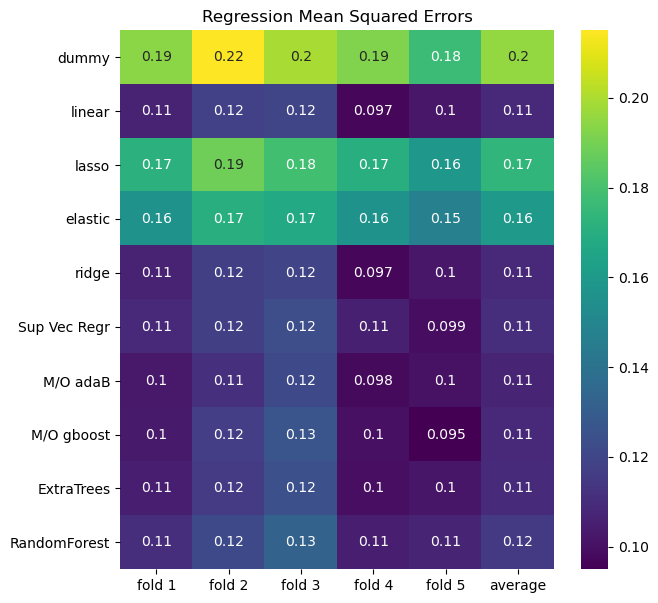

In [85]:
sns.reset_defaults()
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(mse_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression Mean Squared Errors')
plt.savefig('MSE_yeast_met_and_lip_hm_tight_imp.svg', bbox_inches='tight')

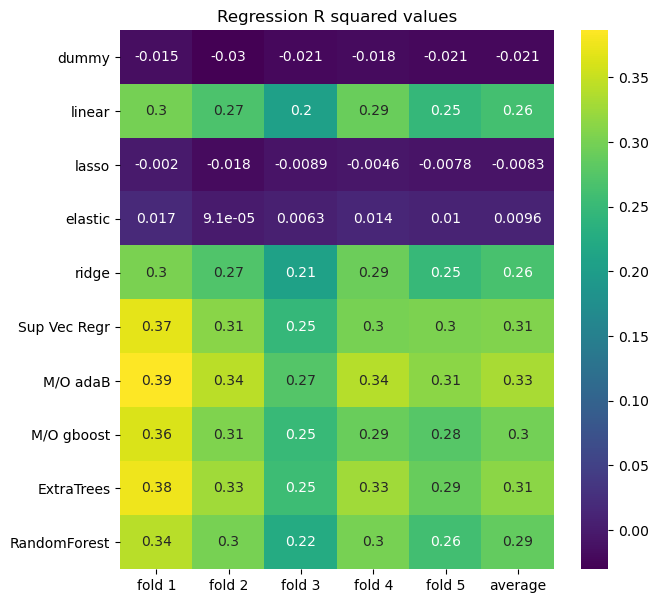

In [84]:
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(r2_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression R squared values')
plt.savefig('r2_yeast_met_and_lip_hm_imp.svg', bbox_inches='tight')